<a href="https://colab.research.google.com/github/maciejskorski/enhanced-pll-trng/blob/main/src/model_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Utilities

Run to install required software and prepare auxiliary functions.

In [1]:
# update Python lib - and restart the kernel when necessary
!pip install --upgrade statsmodels --quiet
!pip install --upgrade seaborn --quiet
!pip install mlflow --quiet
!pip install pyngrok --quiet
!sudo apt-get install tree

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 41.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.1/18.1 MB 20.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.5/83.5 kB 7.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.5/188.5 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 16.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 148.1/148.1 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 681.2/681.2 kB 10.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NE

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import seaborn.objects as so
import pandas as pd
import numpy as np
import tempfile
import io
from scipy import stats
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss

from pathlib import Path
import re
import itertools

from IPython.display import display

import multiprocessing as mp

import logging
import mlflow
from pyngrok import ngrok
from getpass import getpass

plt.rcParams["figure.figsize"] = (10, 3)
logger = logging.getLogger("TRNG Analysis")
logger.setLevel(logging.INFO)


def read_dff(filename, KM, KD):
    """Read dff bits from the raw file. Return a matrix of shape (n_cycles, KD)"""
    bytes_data = np.fromfile(filename, dtype="uint8")  # read bytes
    bits_data = np.unpackbits(bytes_data, axis=None, count=None, bitorder="little")  # unpack to bits
    bits_data = bits_data.reshape((-1, 32))[:, ::-1].ravel()  # reverse bits order in blocks of 32
    bits_data = np.resize(bits_data, (len(bits_data) // KD, KD))  # reshape to cycles
    return bits_data


def get_bytes_data(fpath):
    with open(fpath, "rb") as f:
        bytes_data = f.read()
    bytes_data = pd.DataFrame(list(bytes_data), columns=["byte value"])
    bytes_data.index.name = "timestep"
    return bytes_data


def get_metadata(fpath):
    """Read mean and alan variance, as stored in log* files"""
    with open(fpath, "r") as f:
        metadata = f.read()
        rgx_mean = re.compile("\nMean:\s+(\d+.\d+)")
        rgx_alan = re.compile("\nAllan variance:\s+(\d+.\d+)")
        mean = float(rgx_mean.search(metadata).group(1))
        var_alan = float(rgx_alan.search(metadata).group(1))
        return mean, var_alan


def counter_val(x):
    return x


def last_bit(x):
    return x % 2


def diff_last_bit(x):
    return x.diff().loc[1:] % 2


def analyze_series(bytes_data, nlags=10, alpha=0.05, postprocess_fn=last_bit):
    """Analyze dependencies of TRNG bytes candidate.
    Args:
        bytes_data (pandas.DataFrame): series of raw bytes (das), encoded as integers uint8
        nlags (int): maximum number of lags to analyse
        alpha (float): confidence level for hypothesis testing
        postprocess_fn (function): transform applied to the series. For example, use <mod 2> to extract the last significant bit
    Return:
        figure: picture with plots
    """
    params = {"lags": nlags, "alpha": alpha, "postprocess_fn": postprocess_fn.__name__}
    mlflow.log_params(params)
    fig, axs = plt.subplots(1, 2, constrained_layout=True)
    # plot histogram
    ax = axs[0]
    sns.histplot(data=bytes_data, x="byte value", ax=ax, discrete=True)
    # plot time series
    ax = axs[1]
    sns.lineplot(data=bytes_data.loc[:1000], x="timestep", y="byte value", ax=ax)
    plt.show()
    mlflow.log_figure(fig, "exploratory.png")
    bytes_data = postprocess_fn(bytes_data)
    # descriptive stats
    if postprocess_fn == counter_val:
        mlflow.log_metric("mean", bytes_data.mean())
    # stationarity tests on postprocessed data
    results = kpss(bytes_data, nlags=10)
    pval = results[1]
    mlflow.log_metric(f"stationary.KPSS.lag_{nlags}", pval)
    results = adfuller(bytes_data, maxlag=10)
    pval = results[1]
    mlflow.log_metric(f"not-stationary.ADF.lag_{nlags}", pval)
    # plot autocorelation by
    fig, ax = plt.subplots(1, 1, constrained_layout=True)
    fig = plot_acf(
        x=bytes_data,
        lags=nlags,
        fft=True,
        alpha=alpha,
        bartlett_confint=True,
        zero=False,
        adjusted=True,
        ax=ax,
        auto_ylims=True,
    )
    ax.set(xlabel="Lag", ylabel="Corr")
    plt.show()
    mlflow.log_figure(fig, "autocorrelation.png")
    # find p-values for autocorrelation
    _, _, _, pvals = acf(
        x=bytes_data, nlags=nlags, alpha=alpha, fft=True, bartlett_confint=True, adjusted=True, qstat=True
    )
    pvals = {"lag": np.arange(1, nlags + 1), "Ljung-Box Test p-val": pvals}
    pvals = pd.DataFrame(data=pvals)
    pvals.set_index("lag", inplace=True)
    display(pvals)
    mlflow.log_metric(f"not-correlated.LjungBox.lag_{nlags}", pvals.loc[nlags])

# Logging

Result outcomes are tracked with `mlflow`, and can be interactively presented either under the temporary public address with `ngrok` (request a free token) or locally (pass an empty string).

In [3]:
# Run mlflow server
get_ipython().system_raw("mlflow ui --port 5000 &")

# Terminate open tunnels if exist
ngrok.kill()

# Setting the authtoken (optional)
# Get your authtoken from https://dashboard.ngrok.com/auth or pass an empty string to skip
NGROK_AUTH_TOKEN = getpass('Enter the ngrok authtoken: ')

if NGROK_AUTH_TOKEN:
    ngrok.set_auth_token(NGROK_AUTH_TOKEN)

    # Open an HTTPS tunnel on port 5000 for http://localhost:5000
    ngrok_tunnel = ngrok.connect(addr="5000", proto="http", bind_tls=True)

    # visit the tracking address to enable !
    mlflow.set_tracking_uri(ngrok_tunnel.public_url)
    logger.info(f"MLflow Tracking UI:{ngrok_tunnel.public_url}")
else:
    logger.info(f"MLflow Tracking UI:{mlflow.get_tracking_uri()}")

Enter the ngrok authtoken: ··········


INFO:TRNG Analysis:MLflow Tracking UI:file:///content/mlruns


# Data

Use data from various cards to run the analysis scripts and stasticial tests.

In [4]:
# Download the data when the notebook is run standalone (e.g. in Colab)
import os

if os.getcwd().endswith("src"):
    ROOT_PATH = ".."
else:
    !wget --quiet https://github.com/maciejskorski/enhanced-pll-trng/releases/download/v0.0.3/data.zip
    !unzip -qq data.zip
    ROOT_PATH = "."

!tree -d {ROOT_PATH}/data

N
./data
├── CornerAnalysis
├── ExtremeTemperature
├── Regular
│   ├── CVv12_4
│   │   ├── A_1
│   │   ├── A_2
│   │   ├── B_1
│   │   ├── B_2
│   │   ├── C_1
│   │   └── C_2
│   ├── S6v11_2
│   │   ├── A_1
│   │   ├── A_2
│   │   ├── B_1
│   │   ├── B_2
│   │   ├── C_1
│   │   └── C_2
│   ├── S6v11_8
│   │   ├── A_1
│   │   ├── A_2
│   │   ├── B_1
│   │   ├── B_2
│   │   ├── C_1
│   │   └── C_2
│   └── SF2v11_11
│       ├── A_1
│       ├── A_2
│       ├── B_1
│       ├── B_2
│       ├── C_1
│       └── C_2
└── TemperatureAttack

32 directories


# Analysis

## Configurations

Parse through all data files to extract each configuration's parameters.

In [5]:
from collections import namedtuple

ExpConfig = namedtuple("ExpConfig", "name inputfile KM KD config pll card constraint params")


def generate_configs_cyclonev(root_path=f"{ROOT_PATH}/data/Regular"):
    for fname in Path(root_path).glob("CV*/*/*.bin"):
        if "bit.bin" not in fname.name:
            cfg_name = fname.parent.name
            km_kd_pattern = re.compile("km(\d+)_kd(\d+)")
            KM, KD = map(int, km_kd_pattern.search(str(fname)).groups())
            card_pattern = re.compile("CV(\w+)")
            card = card_pattern.search(str(fname)).groups()[0]
            pll_pattern = re.compile("[A,B,C]_(\d)")
            pll = int(pll_pattern.search(str(fname)).groups()[0])
            config_pattern = re.compile("([A,B,C])_\d")
            config = "CV_" + config_pattern.search(str(fname)).groups()[0]
            yield ExpConfig(
                name=cfg_name,
                inputfile=fname,
                KM=KM,
                KD=KD,
                config=config,
                pll=pll,
                card=card,
                constraint=None,
                params={"bit_pdf": True, "bits_intra_correlation": True},
            )


def generate_configs_spartan(root_path=f"{ROOT_PATH}/data/Regular"):
    for fname in Path(root_path).glob("S6*/*/*.bin"):
        if "bit.bin" not in fname.name:
            cfg_name = fname.parent.name
            km_kd_pattern = re.compile("km(\d+)_kd(\d+)")
            KM, KD = map(int, km_kd_pattern.search(str(fname)).groups())
            card_pattern = re.compile("S6(\w+)")
            card = card_pattern.search(str(fname)).groups()[0]
            pll_pattern = re.compile("[A,B,C]_(\d)")
            pll = int(pll_pattern.search(str(fname)).groups()[0])
            config_pattern = re.compile("([A,B,C])_\d")
            config = "S6_" + config_pattern.search(str(fname)).groups()[0].upper()
            yield ExpConfig(
                name=cfg_name,
                inputfile=fname,
                KM=KM,
                KD=KD,
                pll=pll,
                card=card,
                config=config,
                constraint=None,
                params={"bit_pdf": True, "bits_intra_correlation": True},
            )


def generate_configs_smartfusion(root_path=f"{ROOT_PATH}/data/Regular"):
    for fname in Path(root_path).glob("SF*/*/*.bin"):
        if "bit.bin" not in fname.name:
            cfg_name = fname.parent.name
            km_kd_pattern = re.compile("km(\d+)_kd(\d+)")
            KM, KD = map(int, km_kd_pattern.search(str(fname)).groups())
            card_pattern = re.compile("SF2(\w+)")
            card = card_pattern.search(str(fname)).groups()[0]
            pll_pattern = re.compile("[A,B,C]_(\d)")
            pll = int(pll_pattern.search(str(fname)).groups()[0])
            config_pattern = re.compile("([A,B,C])_\d")
            config = "SF_" + config_pattern.search(str(fname)).groups()[0].upper()
            yield ExpConfig(
                name=cfg_name,
                inputfile=fname,
                KM=KM,
                KD=KD,
                pll=pll,
                card=card,
                config=config,
                constraint=None,
                params={"bit_pdf": True, "bits_intra_correlation": True},
            )


def generate_configs_special(root_path="/CV_special"):
    for fname in Path(root_path).glob("*/*/*.bin"):
        if "bit.bin" not in fname.name:
            cfg_name = fname.parent.name
            km_kd_pattern = re.compile("km(\d+)_kd(\d+)")
            KM, KD = map(int, km_kd_pattern.search(str(fname)).groups())
            card_pattern = re.compile("Card_M(\d)")
            card = int(card_pattern.search(str(fname)).groups()[0])
            pll_pattern = re.compile("\w_(\d)/acq")
            pll = int(pll_pattern.search(str(fname)).groups()[0])
            config_pattern = re.compile("(\w+)_\d/acq")
            config = "_".join(config_pattern.search(str(fname)).groups())
            yield ExpConfig(
                name=cfg_name,
                inputfile=fname,
                KM=KM,
                KD=KD,
                pll=pll,
                card=card,
                config=config,
                constraint=None,
                params={"bit_pdf": True, "bits_intra_correlation": True},
            )


cfgs = list(generate_configs_cyclonev())
assert len(cfgs) == 6

cfgs = list(generate_configs_spartan())
assert len(cfgs) == 12

cfgs = list(generate_configs_smartfusion())
assert len(cfgs) == 6

## Stationarity

Run the KPSS and ADF statistical tests against all configurations, to check for stationarity of counter and raw values.

Note: the KPSS implementation warns that p-values are rounded to the supported range 0.01 - 0.10. Hence, 0.01 should be treated as rejection.

In [6]:
experiment_name = "Stationarity tests for output bits"
experiment_id = mlflow.create_experiment(experiment_name)


def counter_val(x):
    return x


def last_bit(x):
    return x % 2


def get_stationarity(cfg, alpha=0.05):
    for postprocess_fn in [counter_val, last_bit]:
        with mlflow.start_run(experiment_id=experiment_id):
            mlflow.log_param("file", cfg.inputfile)
            mlflow.log_param("KM", cfg.KM)
            mlflow.log_param("KD", cfg.KD)
            mlflow.log_param("config", cfg.config)
            mlflow.log_param("pll", cfg.pll)
            mlflow.log_param("card", cfg.card)
            mlflow.log_param("postprocessing", postprocess_fn.__name__)
            KM = cfg.KM
            KD = cfg.KD
            bits = read_dff(cfg.inputfile, KM=KM, KD=KD)
            bits = bits.astype("int32")
            counter = bits.sum(1)
            results = kpss(postprocess_fn(counter))
            pval = results[1]
            mlflow.log_metric("KPSS", pval)
            results = adfuller(postprocess_fn(counter), maxlag=10)
            pval = results[1]
            mlflow.log_metric("ADF", pval)


all_configs = itertools.chain(generate_configs_cyclonev(), generate_configs_spartan(), generate_configs_smartfusion())
all_configs = filter(lambda c: c.pll == 1, all_configs)


with mp.Pool(4) as p:
    p.map(get_stationarity, all_configs)

<ipython-input-6-feb34fc82ad5>:28: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  results = kpss(postprocess_fn(counter))
<ipython-input-6-feb34fc82ad5>:28: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  results = kpss(postprocess_fn(counter))
<ipython-input-6-feb34fc82ad5>:28: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  results = kpss(postprocess_fn(counter))
<ipython-input-6-feb34fc82ad5>:28: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  results = kpss(postprocess_fn(counter))
<ipython-input-6-feb34fc

In [7]:
keep_cols = [
    "metrics.KPSS",
    "metrics.ADF",
    "params.config",
    "params.card",
    "params.postprocessing",
]
filter_string = "params.pll='1'"
out = mlflow.search_runs(experiment_id, filter_string=filter_string)[keep_cols]
out.columns = map(lambda s: s.replace("metrics.", "").replace("params.", ""), out.columns)
postprocess_dict = {"counter_val": "counter", "last_bit": "raw bit"}
out["postprocessing"] = out["postprocessing"].apply(postprocess_dict.get)
CARD_DICT = {"v11_11": 1, "v11_2": 1, "v11_8": 2, "v12_4": 1}
out["card"] = out["config"].str.slice(0, 2) + out["card"].apply(CARD_DICT.get).astype(str)
out = pd.melt(
    out,
    id_vars=[
        "config",
        "card",
        "postprocessing",
    ],
    value_vars=["KPSS", "ADF"],
    var_name="test",
)
out = out.pivot(index=["config", "card"], columns=["postprocessing", "test"])
out.columns = out.columns.droplevel(0)
out.columns.names = ["contributors", "test"]
key = out.index.get_level_values("config").to_series()
key = key.str.slice(
    -1,
) + key.str.slice(0, -1)
out = (
    out.set_index(
        key,
        append=True,
    )
    .sort_index(level=-1)
    .droplevel(-1)
)
out = out.reindex(columns=["counter", "raw bit"], level=0)
out_stationarity = out

ALPHA = 0.01

style_TRNG_OK = "color:Green; font-weight: bold"
out = (
    out.style.format(precision=2, escape="latex")
    .applymap(
        lambda x: style_TRNG_OK if x >= ALPHA else "",
        subset=[
            (
                "counter",
                "KPSS",
            )
        ],
    )
    .applymap(
        lambda x: style_TRNG_OK if x >= ALPHA else "",
        subset=[
            (
                "raw bit",
                "KPSS",
            )
        ],
    )
    .applymap(
        lambda x: style_TRNG_OK if x < ALPHA else "",
        subset=[
            (
                "counter",
                "ADF",
            )
        ],
    )
    .applymap(
        lambda x: style_TRNG_OK if x < ALPHA else "",
        subset=[
            (
                "raw bit",
                "ADF",
            )
        ],
    )
)


display(out)

latex_code = out.to_latex(
    hrules=True,
    convert_css=True,
    position_float="centering",
    caption="Results of stationarity tests (p-values for KPSS and ADF tests).",
    label="tab:output_stationarity",
)

latex_code = latex_code.replace("_A", "\_A")
latex_code = latex_code.replace("_B", "\_B")
latex_code = latex_code.replace("_C", "\_C")
latex_code

'\\begin{table}\n\\centering\n\\caption{Results of stationarity tests (p-values for KPSS and ADF tests).}\n\\label{tab:output_stationarity}\n\\begin{tabular}{llrrrr}\n\\toprule\n & contributors & \\multicolumn{2}{r}{counter} & \\multicolumn{2}{r}{raw bit} \\\\\n & test & KPSS & ADF & KPSS & ADF \\\\\nconfig & card &  &  &  &  \\\\\n\\midrule\nCV\\_A & CV1 & \\color{Green} \\bfseries 0.01 & \\color{Green} \\bfseries 0.00 & \\color{Green} \\bfseries 0.10 & \\color{Green} \\bfseries 0.00 \\\\\n\\multirow[c]{2}{*}{S6\\_A} & S61 & \\color{Green} \\bfseries 0.07 & \\color{Green} \\bfseries 0.00 & \\color{Green} \\bfseries 0.06 & \\color{Green} \\bfseries 0.00 \\\\\n & S62 & \\color{Green} \\bfseries 0.05 & \\color{Green} \\bfseries 0.00 & \\color{Green} \\bfseries 0.10 & \\color{Green} \\bfseries 0.00 \\\\\nSF\\_A & SF1 & \\color{Green} \\bfseries 0.02 & \\color{Green} \\bfseries 0.00 & \\color{Green} \\bfseries 0.10 & \\color{Green} \\bfseries 0.00 \\\\\nCV\\_B & CV1 & \\color{Green} \\bfse

## Serial Correlation

Run the Ljung-Box statistical test against all configurations, to check for correlations between counter values, as well as dff outputs.

In [8]:
experiment_name = "Serial correlation tests for output bits"
experiment_id = mlflow.create_experiment(experiment_name)


def get_correlation(cfg, alpha=0.01):
    for postprocess_fn in [counter_val, last_bit]:
        with mlflow.start_run(experiment_id=experiment_id):
            mlflow.log_param("file", cfg.inputfile)
            mlflow.log_param("KM", cfg.KM)
            mlflow.log_param("KD", cfg.KD)
            mlflow.log_param("config", cfg.config)
            mlflow.log_param("pll", cfg.pll)
            mlflow.log_param("card", cfg.card)
            mlflow.log_param("postprocessing", postprocess_fn.__name__)
            mlflow.log_param("confidence", alpha)
            KM = cfg.KM
            KD = cfg.KD
            bits = read_dff(cfg.inputfile, KM=KM, KD=KD)
            bits = bits.astype("int32")
            counter = bits.sum(1)
            _, _, _, pvals = acf(
                postprocess_fn(counter), qstat=True, alpha=alpha
            )  # by default nlags is logarithmic in the sample size
            pval = pvals[-1]
            mlflow.log_metric("LjungBox", pval)


all_configs = itertools.chain(generate_configs_cyclonev(), generate_configs_spartan(), generate_configs_smartfusion())
all_configs = filter(lambda c: c.pll == 1, all_configs)


with mp.Pool(4) as p:
    p.map(get_correlation, all_configs)

In [9]:
keep_cols = ["metrics.LjungBox", "params.config", "params.card", "params.postprocessing"]
filter_string = 'params.pll="1"'
out = mlflow.search_runs(experiment_id, filter_string=filter_string)[keep_cols]
out.columns = map(lambda s: s.replace("metrics.", "").replace("params.", ""), out.columns)
CARD_DICT = {"v11_11": 1, "v11_2": 1, "v11_8": 2, "v12_4": 1}
out["card"] = out["config"].str.slice(0, 2) + out["card"].apply(CARD_DICT.get).astype(str)
postprocess_dict = {"counter_val": "counter", "last_bit": "raw bit"}
out["postprocessing"] = out["postprocessing"].apply(postprocess_dict.get)
out = out.pivot(index=["config", "card"], columns="postprocessing")
key = out.index.get_level_values("config").to_series()
key = key.str.slice(
    -1,
) + key.str.slice(0, -1)
out = (
    out.set_index(
        key,
        append=True,
    )
    .sort_index(level=-1)
    .droplevel(-1)
)
out.columns.names = ["test", "contributors"]
out = out.reorder_levels([1, 0], axis=1)
out_correlation = out

ALPHA = 0.01

style_TRNG_OK = "color:Green; font-weight: bold"
out = (
    out.style.format(precision=2, escape="latex")
    .applymap(lambda x: style_TRNG_OK if x >= ALPHA else "", subset=[("counter", "LjungBox")])
    .applymap(lambda x: style_TRNG_OK if x >= ALPHA else "", subset=[("raw bit", "LjungBox")])
)

display(out)

latex_code = out.to_latex(
    hrules=True,
    convert_css=True,
    position_float="centering",
    caption="Results of serial correlation tests",
    label="tab:serial_correlation",
)

latex_code = latex_code.replace("_A", "\_A")
latex_code = latex_code.replace("_B", "\_B")
latex_code = latex_code.replace("_C", "\_C")
latex_code

'\\begin{table}\n\\centering\n\\caption{Results of serial correlation tests}\n\\label{tab:serial_correlation}\n\\begin{tabular}{llrr}\n\\toprule\n & contributors & counter & raw bit \\\\\n & test & LjungBox & LjungBox \\\\\nconfig & card &  &  \\\\\n\\midrule\nCV\\_A & CV1 & 0.00 & \\color{Green} \\bfseries 0.07 \\\\\n\\multirow[c]{2}{*}{S6\\_A} & S61 & \\color{Green} \\bfseries 0.63 & \\color{Green} \\bfseries 0.36 \\\\\n & S62 & \\color{Green} \\bfseries 0.38 & \\color{Green} \\bfseries 0.16 \\\\\nSF\\_A & SF1 & 0.00 & \\color{Green} \\bfseries 0.34 \\\\\nCV\\_B & CV1 & 0.00 & \\color{Green} \\bfseries 0.36 \\\\\n\\multirow[c]{2}{*}{S6\\_B} & S61 & 0.00 & \\color{Green} \\bfseries 0.64 \\\\\n & S62 & \\color{Green} \\bfseries 0.04 & \\color{Green} \\bfseries 0.63 \\\\\nSF\\_B & SF1 & 0.00 & \\color{Green} \\bfseries 0.65 \\\\\nCV\\_C & CV1 & \\color{Green} \\bfseries 0.61 & \\color{Green} \\bfseries 0.93 \\\\\n\\multirow[c]{2}{*}{S6\\_C} & S61 & \\color{Green} \\bfseries 0.38 & \\col

## Local Stationarity

Run the loc-KPSS test against all configurations, to check for stationarity of DFF outputs.

In [10]:
experiment_name = "Local stationarity tests for sampled bits"
experiment_id = mlflow.create_experiment(experiment_name)


def kpss_multivariate(x, n_lag=200):
    resids = x - x.mean(0)
    S = resids.T.dot(resids) / len(resids)
    autocov = [resids[lag:,].T.dot(resids[: len(resids) - lag,]) for lag in range(0, n_lag + 1)]
    ws = 2 * np.arange(len(autocov)) / len(autocov)
    ws[0] = 1
    S = (ws.reshape(-1, 1, 1) * autocov).sum(0) / len(resids)
    resids_cum = resids.cumsum(axis=0)
    C = np.tensordot(resids_cum, resids_cum, axes=[(0,), (0,)]) / len(resids) ** 2
    zeta = np.trace(C * np.linalg.inv(S))
    return zeta


def kpss_multivariate_local(x, n_lag=200, n_window=10000):
    x_block = np.resize(x, (x.shape[0] // n_window, n_window, x.shape[1]))
    statistics = list(map(kpss_multivariate, x_block))
    statistics = np.array(statistics)
    return statistics


def get_local_stationarity(cfg, alpha=0.01, n_window=10000, experiment_id=experiment_id):
    with mlflow.start_run(experiment_id=experiment_id):
        mlflow.log_param("file", cfg.inputfile)
        mlflow.log_param("KM", cfg.KM)
        mlflow.log_param("KD", cfg.KD)
        mlflow.log_param("config", cfg.config)
        mlflow.log_param("pll", cfg.pll)
        mlflow.log_param("card", cfg.card)
        KM = cfg.KM
        KD = cfg.KD
        bits = read_dff(cfg.inputfile, KM=KM, KD=KD)
        bits = bits.astype("int32")
        ps = bits.mean(0)
        good_idxs = np.arange(len(ps))[(ps >= 0.05) & (ps <= 0.95)]
        contrib_bits = bits[:, good_idxs]
        mlflow.log_metric("n_contribs", contrib_bits.shape[1])
        mlflow.log_metric("n_periods", contrib_bits.shape[0])
        stats = kpss_multivariate_local(contrib_bits, n_window=n_window)
        stat = np.median(stats)
        mlflow.log_metric("test val", stat)
        fig, ax = plt.subplots()
        sns.scatterplot(x=np.arange(len(stats)), y=stats, ax=ax)
        ax.set_title(f"KPSS test for sampled bits over blocks of {n_window} periods.")
        ax.set_xlabel("block")
        ax.set_ylabel("test statistic")
        mlflow.log_figure(fig, "local_stationarity.svg")


all_configs = itertools.chain(generate_configs_cyclonev(), generate_configs_spartan(), generate_configs_smartfusion())
all_configs = filter(lambda c: c.pll == 1, all_configs)


with mp.Pool(4) as p:
    p.map(get_local_stationarity, all_configs)

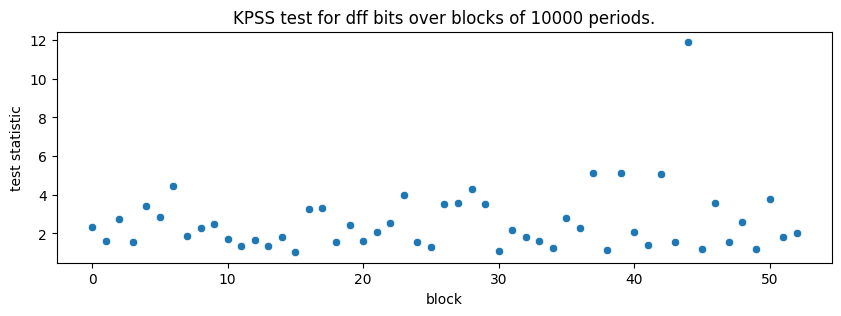

In [11]:
# one example
fname = f"{ROOT_PATH}/data/Regular/S6v11_2/B_1/acq_20230405133036_km464_kd475_dff.bin"
KM = 464
KD = 475
bits = read_dff(fname, KM=KM, KD=KD)
bits = bits.astype("int32")
n_window = 10000
ps = bits.mean(0)
good_idxs = np.arange(len(ps))[(ps >= 0.05) & (ps <= 0.95)]
contrib_bits = bits[:, good_idxs]
stats = kpss_multivariate_local(contrib_bits, n_window=n_window)
fig, ax = plt.subplots()
sns.scatterplot(x=np.arange(len(stats)), y=stats, ax=ax)
ax.set_title(f"KPSS test for dff bits over blocks of {n_window} periods.")
ax.set_xlabel("block")
ax.set_ylabel("test statistic")
plt.show()

In [12]:
from scipy.interpolate import UnivariateSpline

# according to the literatue, the critical value depends on the vector dimension
extreme_values = {
    1: 0.727,
    2: 1.078,
    3: 1.370,
    4: 1.626,
    5: 1.874,
    10: 3.022,
    20: 5.186,
    30: 7.187,
    40: 9.179,
    50: 11.018,
}
extreme_values = pd.DataFrame(extreme_values.items(), columns=["dim", "val"])
spl = UnivariateSpline(extreme_values["dim"], extreme_values["val"])

In [13]:
keep_cols = ["params.config", "params.card", "metrics.n_periods", "metrics.n_contribs", "metrics.test val"]
data = mlflow.search_runs(experiment_id)[keep_cols].dropna()
data.columns = map(lambda s: s.replace("metrics.", "").replace("params.", ""), data.columns)
data["critical val"] = data["n_contribs"].apply(spl)
data["pval"] = data["critical val"] <= data["test val"]
data["pval"] = data["pval"].apply(lambda t: 0.01 if t == True else 0.1)
CARD_DICT = {"v11_11": 1, "v11_2": 1, "v11_8": 2, "v12_4": 1}
data["card"] = data["config"].str.slice(0, 2) + data["card"].apply(CARD_DICT.get).astype(str)
data.to_csv(f"{experiment_name}.csv")
data.set_index(["config", "card"], inplace=True)
key = data.index.get_level_values("config").to_series()
key = key.str.slice(
    -1,
) + key.str.slice(0, -1)
data = (
    data.set_index(
        key,
        append=True,
    )
    .sort_index(level=-1)
    .droplevel(-1)
)
data = data[["pval"]]
data = data.rename({"pval": "loc-KPSS"}, axis=1)
data.columns.name = "test"
data = pd.concat([data], keys=["dff"], names=["contributors"], axis=1)
out_locstationary = data

display(data)

contributors      dff
test         loc-KPSS
config card          
CV_A   CV1       0.10
S6_A   S61       0.10
       S62       0.10
SF_A   SF1       0.10
CV_B   CV1       0.10
S6_B   S61       0.10
       S62       0.10
SF_B   SF1       0.10
CV_C   CV1       0.10
S6_C   S61       0.10
       S62       0.10
SF_C   SF1       0.01

## Intra Correlations

Analyze intra-period dependencies by means of correlation matrices.

### Auto-correlation matrix

INFO:TRNG Analysis:Doing experiment C_1 with params {'bit_pdf': True, 'bits_intra_correlation': True}
INFO:TRNG Analysis:Doing experiment B_1 with params {'bit_pdf': True, 'bits_intra_correlation': True}
INFO:TRNG Analysis:Doing experiment B_1 with params {'bit_pdf': True, 'bits_intra_correlation': True}
INFO:TRNG Analysis:Doing experiment C_2 with params {'bit_pdf': True, 'bits_intra_correlation': True}


OK
OKOK
OK



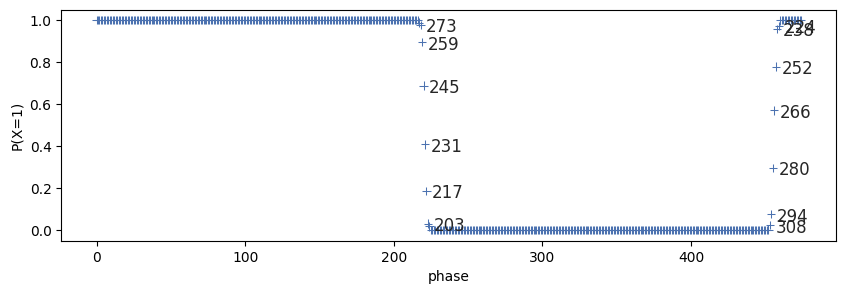

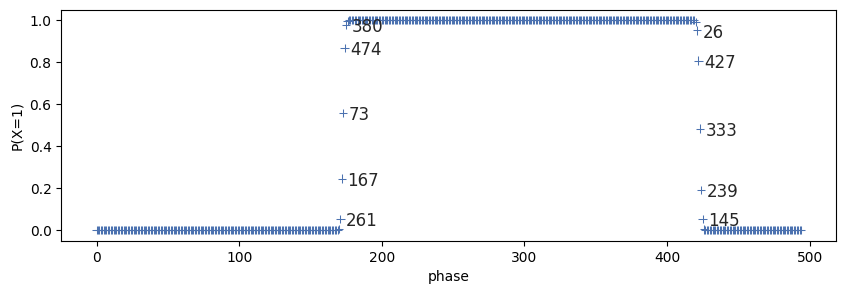

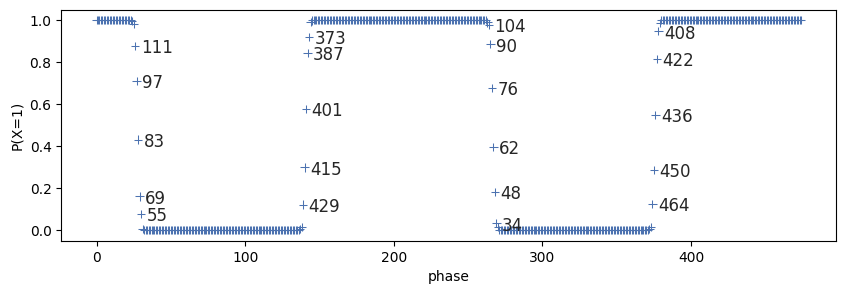

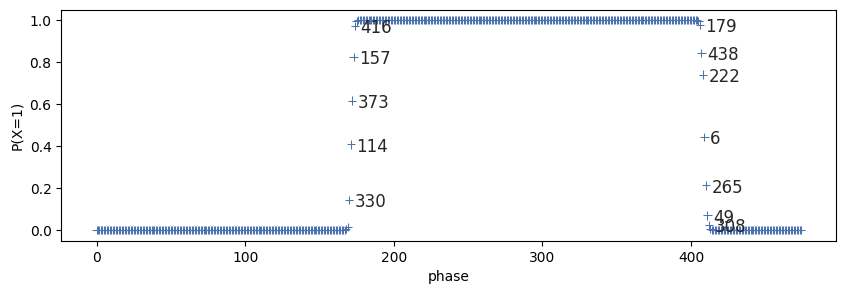

INFO:TRNG Analysis:Doing experiment B_2 with params {'bit_pdf': True, 'bits_intra_correlation': True}
INFO:TRNG Analysis:Doing experiment B_2 with params {'bit_pdf': True, 'bits_intra_correlation': True}
INFO:TRNG Analysis:Doing experiment A_2 with params {'bit_pdf': True, 'bits_intra_correlation': True}


OK
OK
OK


INFO:TRNG Analysis:Doing experiment A_1 with params {'bit_pdf': True, 'bits_intra_correlation': True}


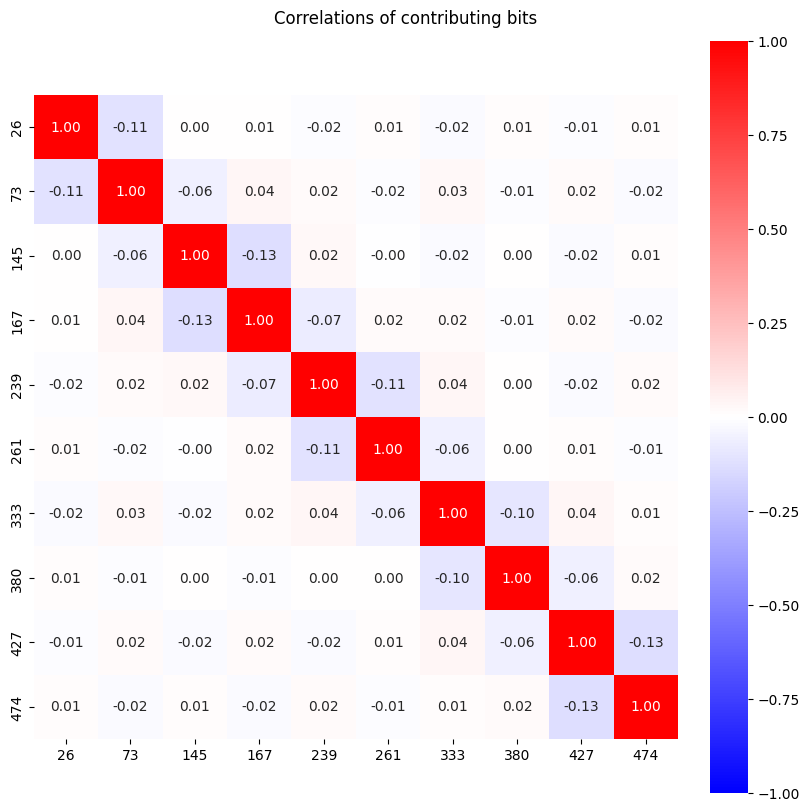

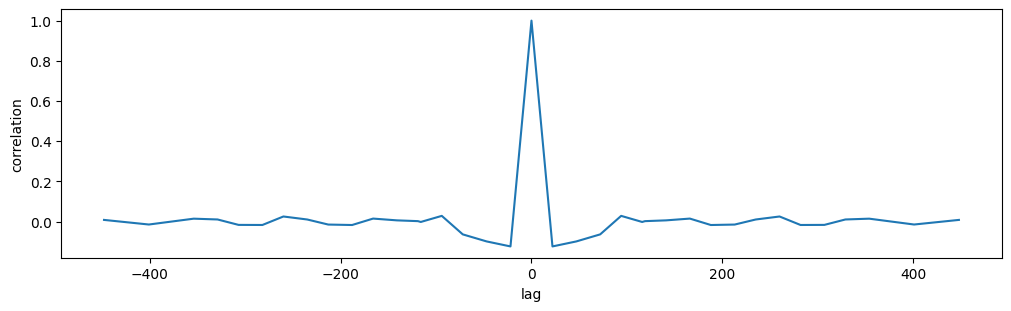

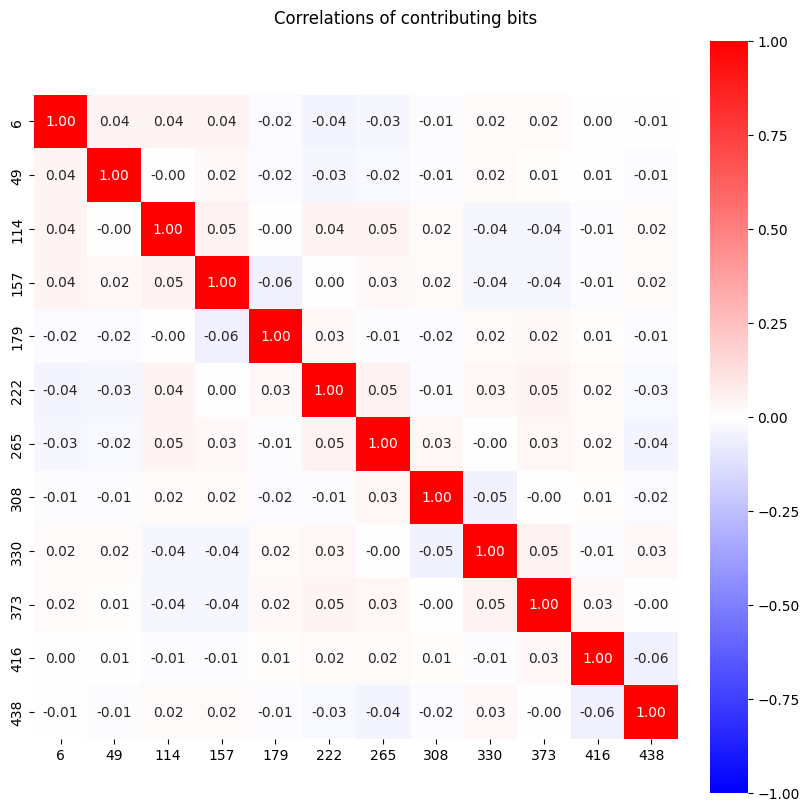

OK


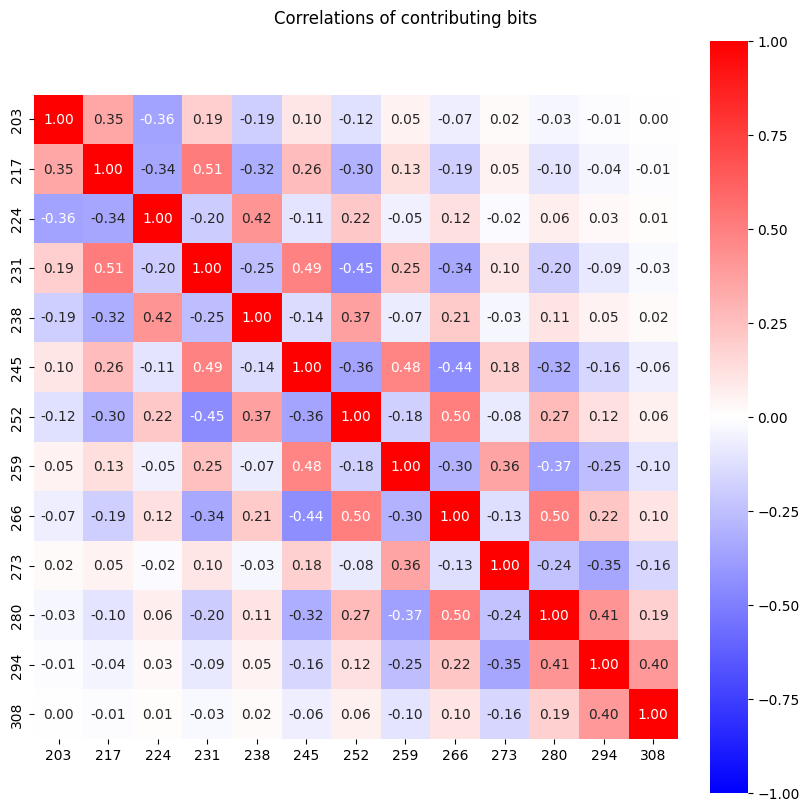

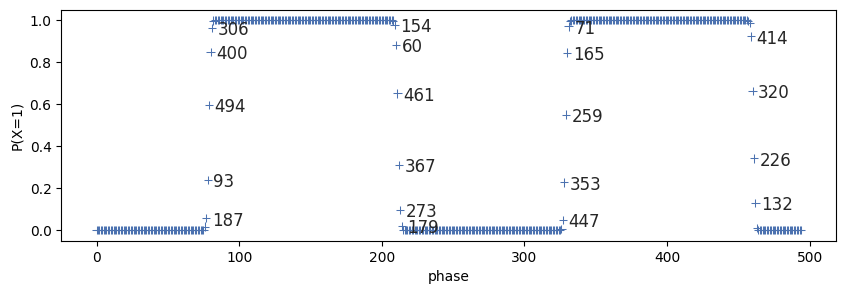

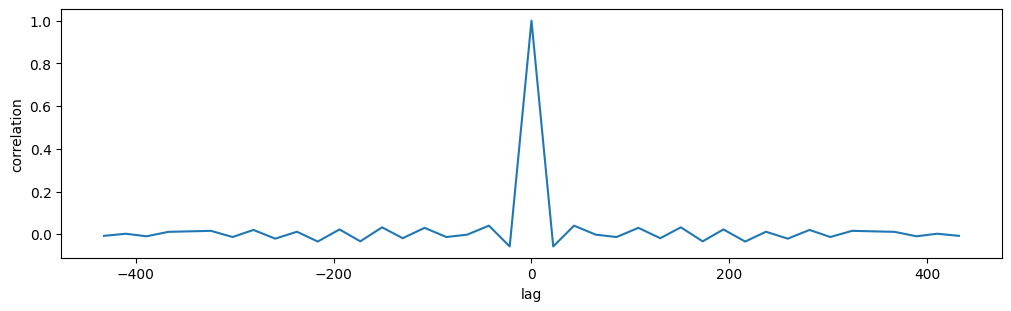

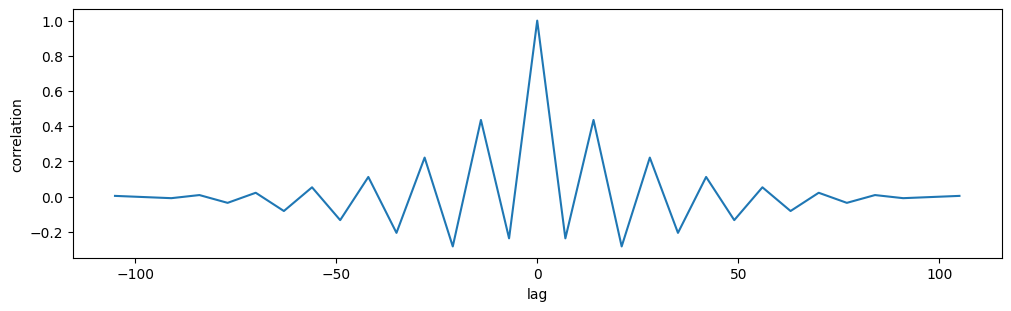

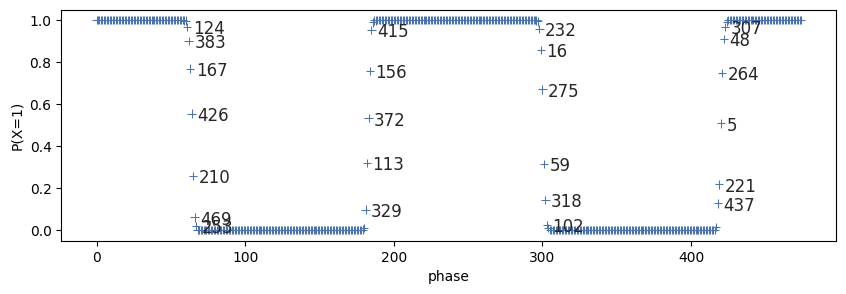

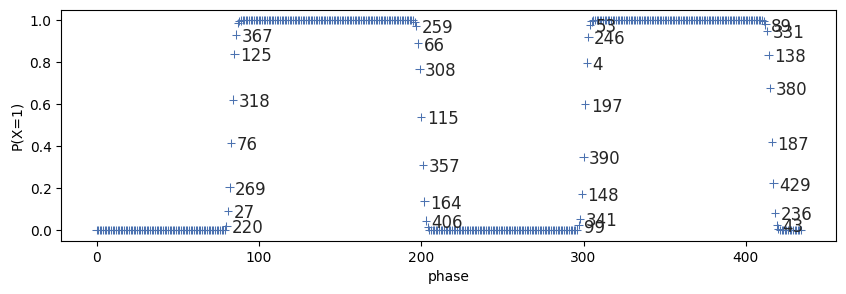

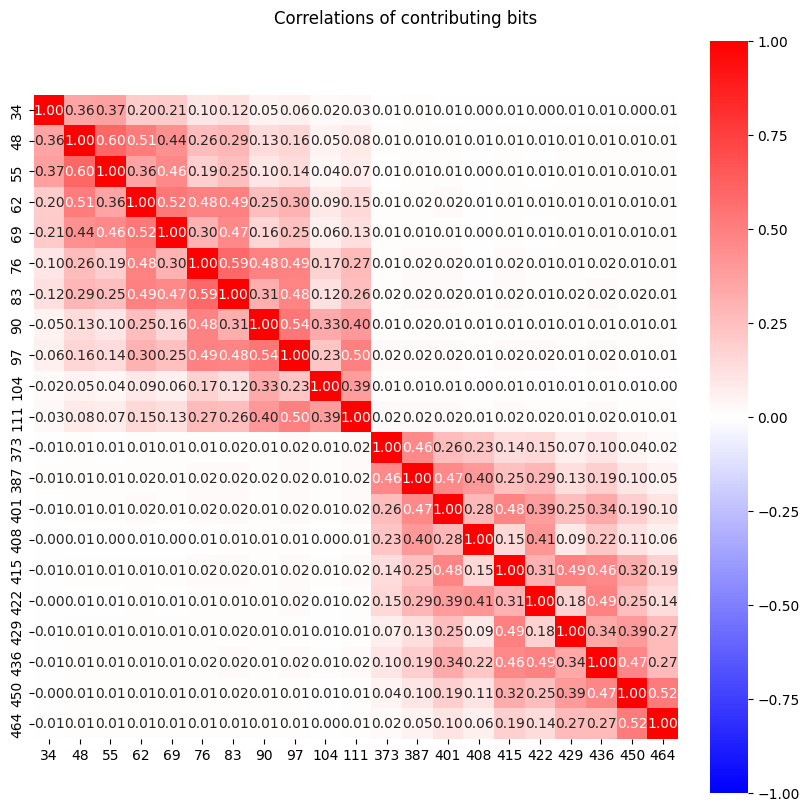

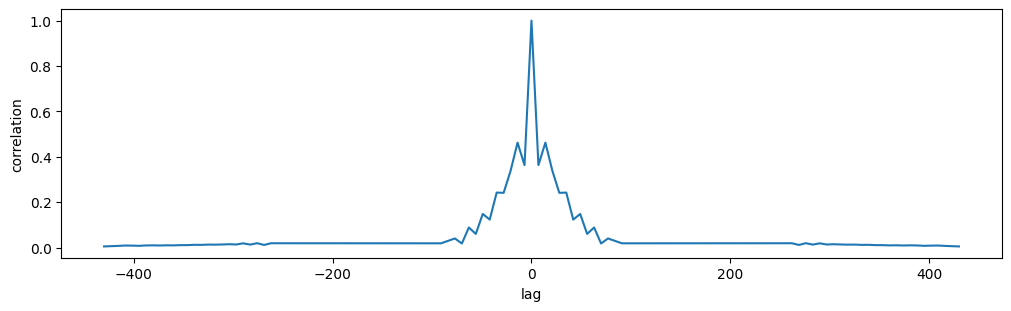

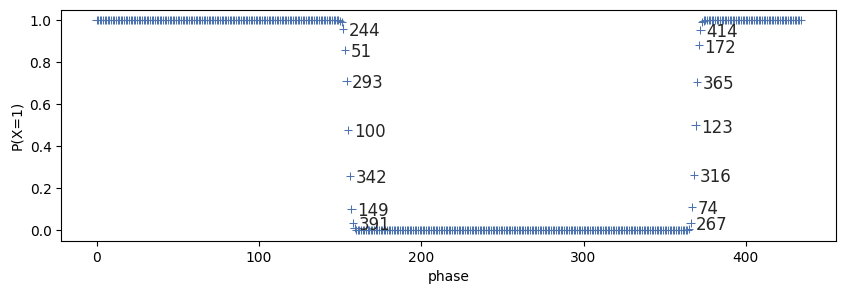

INFO:TRNG Analysis:Doing experiment C_2 with params {'bit_pdf': True, 'bits_intra_correlation': True}


OK


INFO:TRNG Analysis:Doing experiment C_1 with params {'bit_pdf': True, 'bits_intra_correlation': True}
INFO:TRNG Analysis:Doing experiment B_1 with params {'bit_pdf': True, 'bits_intra_correlation': True}


OK
OK


INFO:TRNG Analysis:Doing experiment C_2 with params {'bit_pdf': True, 'bits_intra_correlation': True}


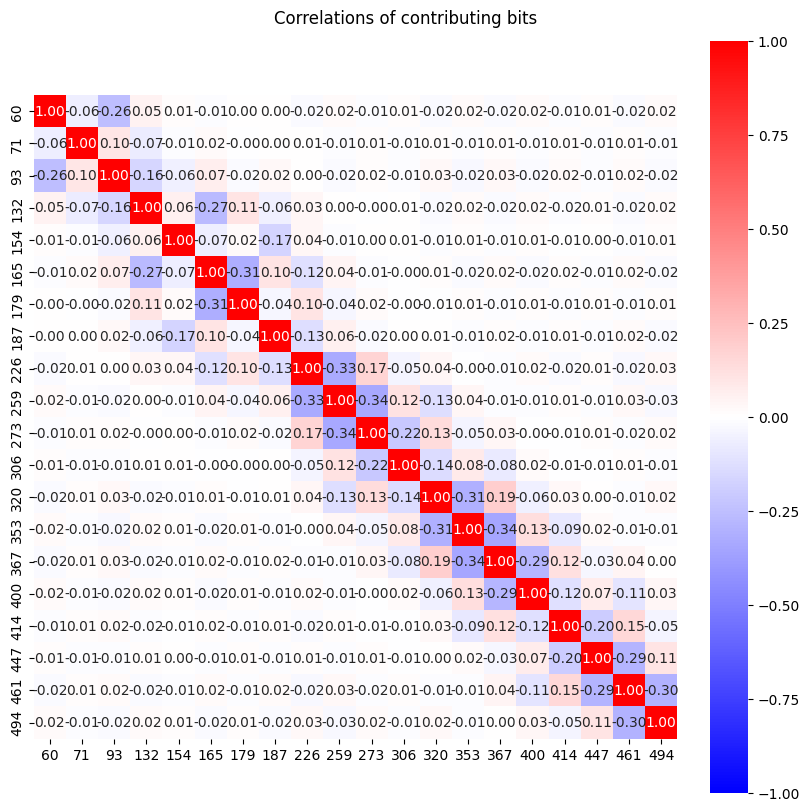

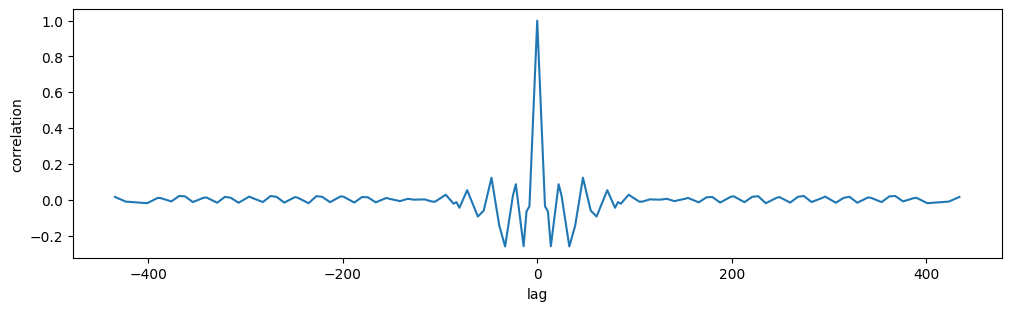

OK


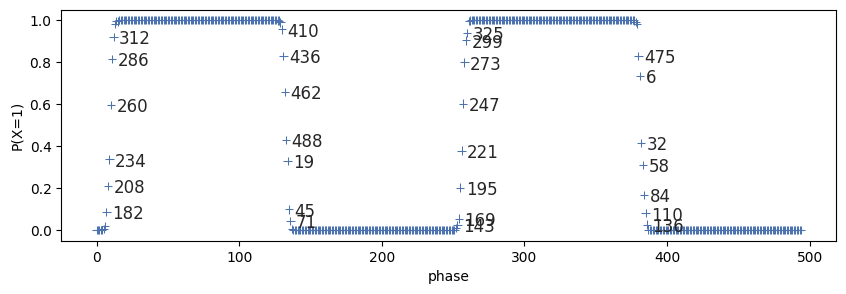

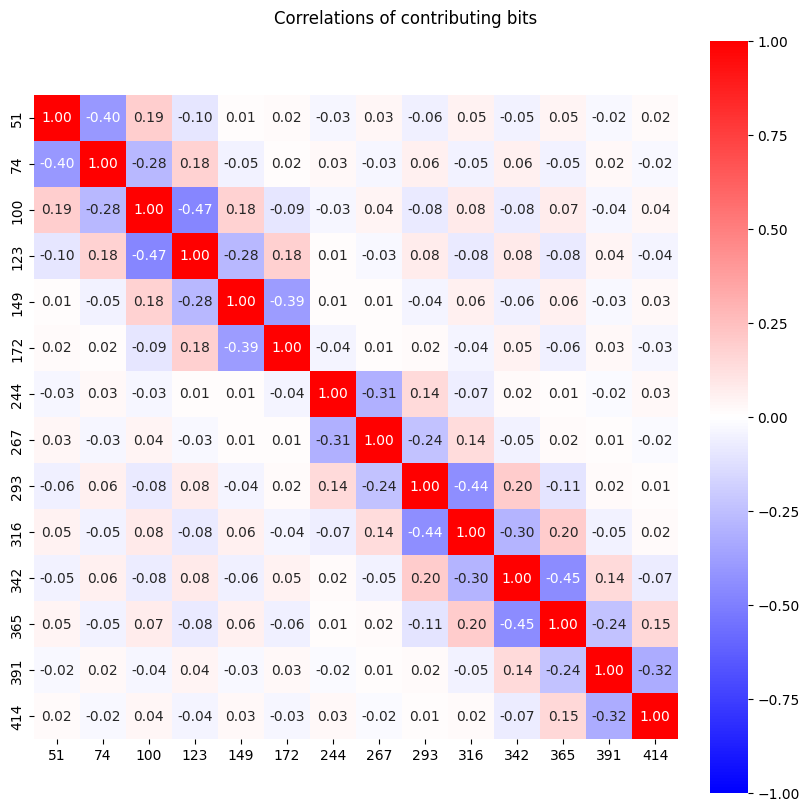

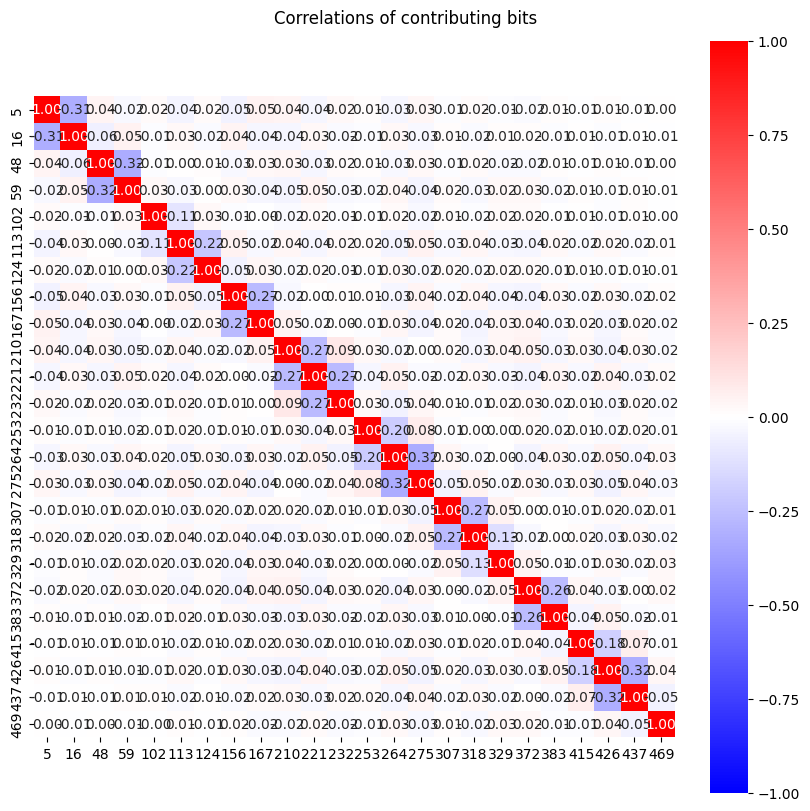

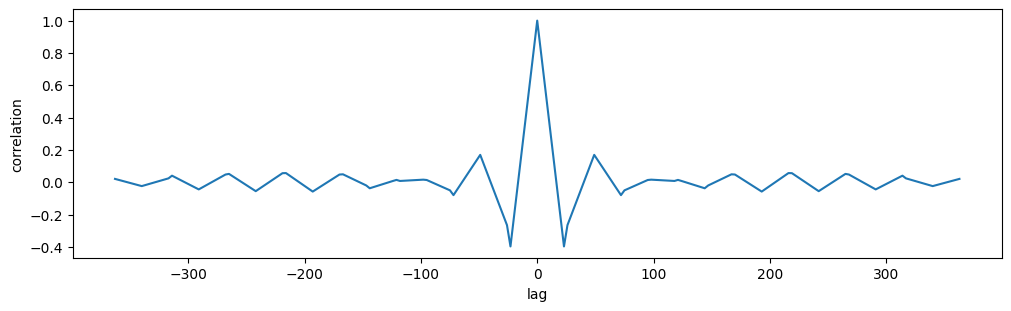

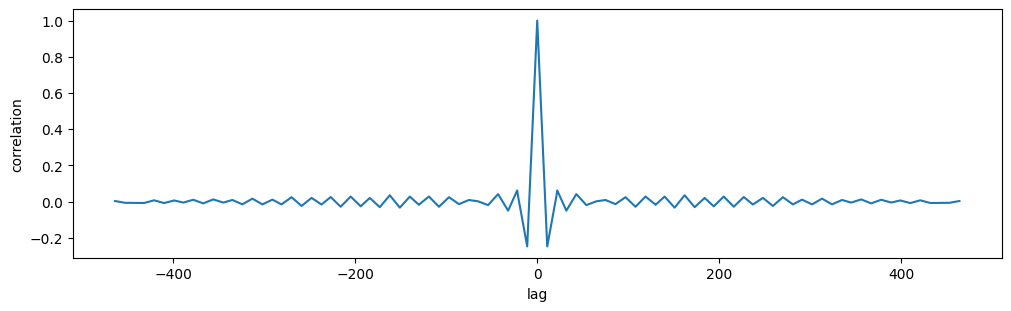

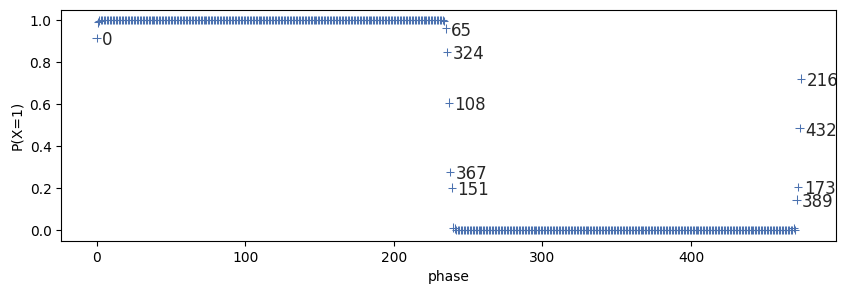

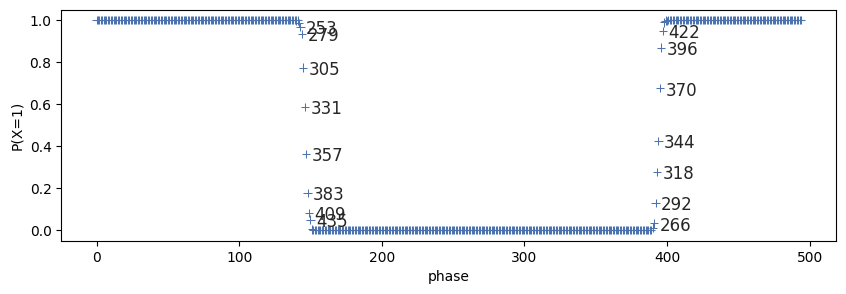

INFO:TRNG Analysis:Doing experiment B_2 with params {'bit_pdf': True, 'bits_intra_correlation': True}


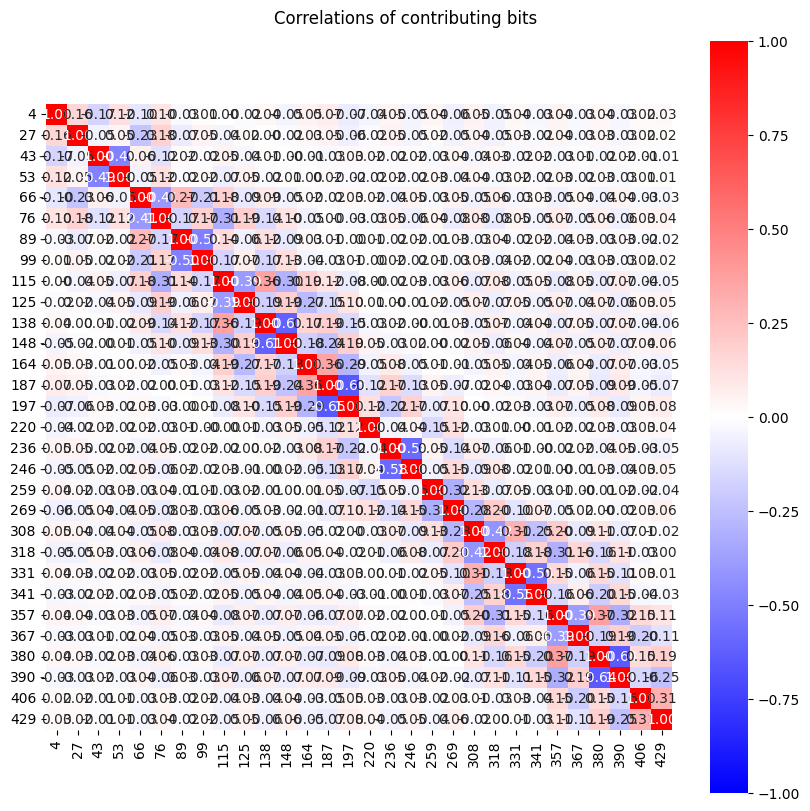

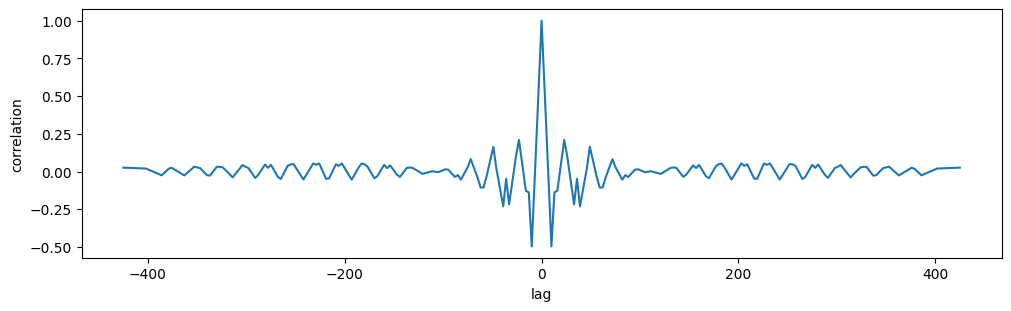

INFO:TRNG Analysis:Doing experiment A_2 with params {'bit_pdf': True, 'bits_intra_correlation': True}


OK


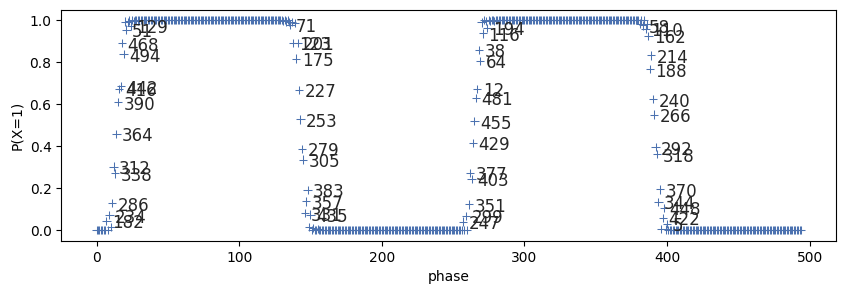

OK


INFO:TRNG Analysis:Doing experiment A_1 with params {'bit_pdf': True, 'bits_intra_correlation': True}


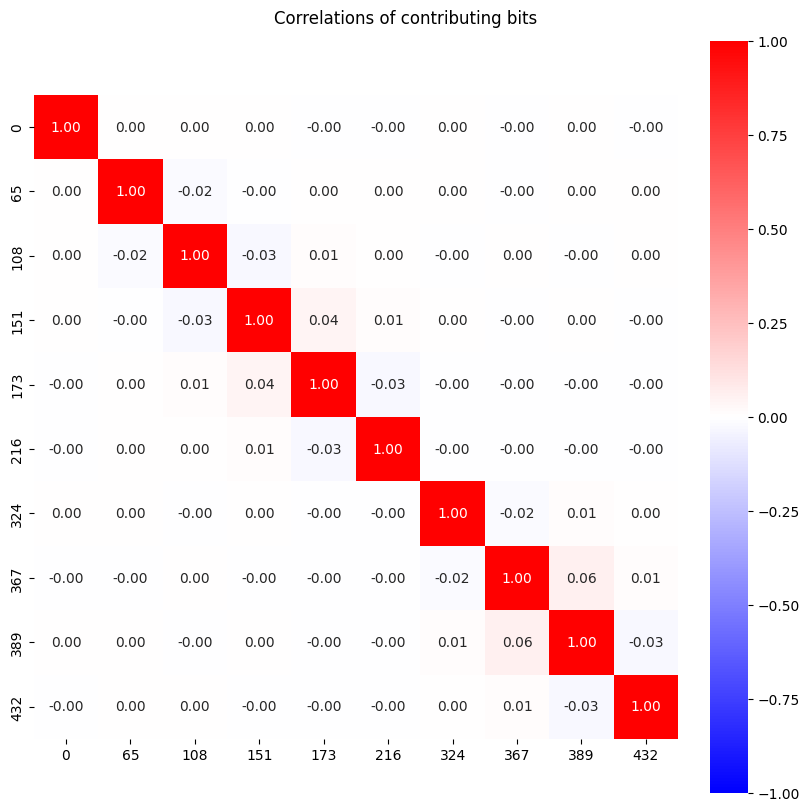

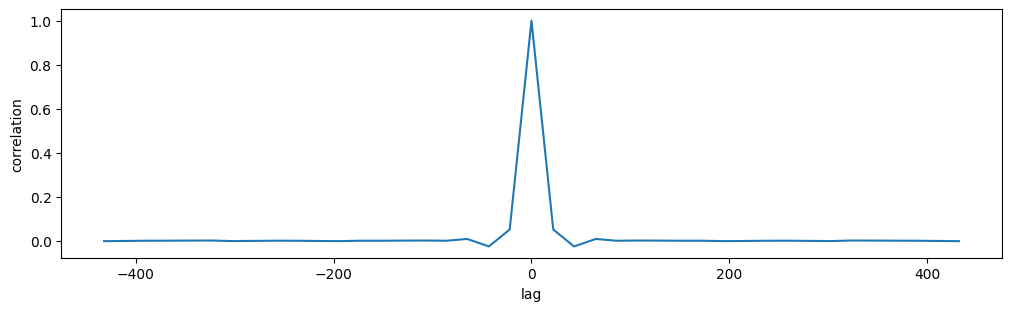

OK


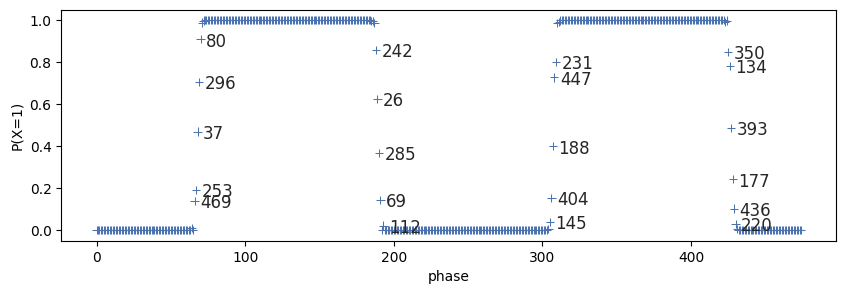

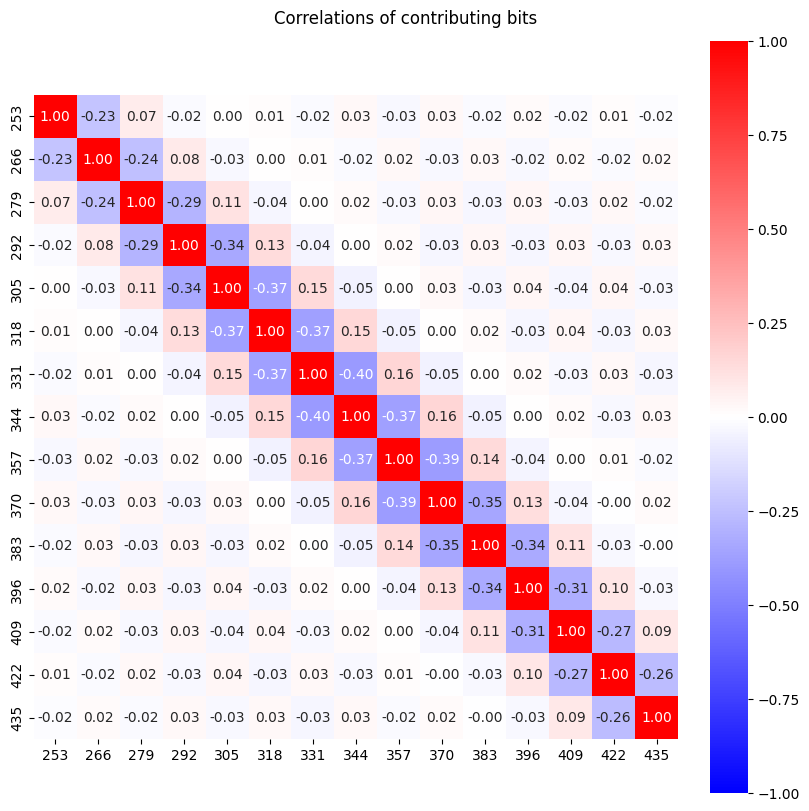

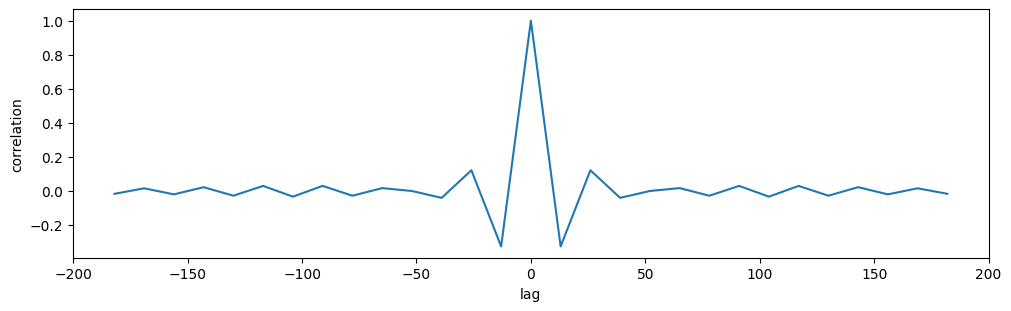

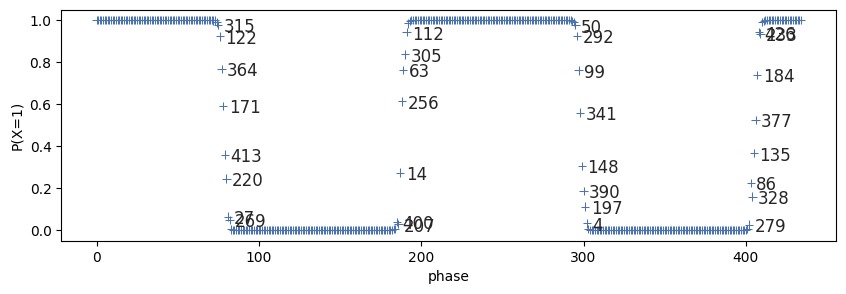

INFO:TRNG Analysis:Doing experiment C_1 with params {'bit_pdf': True, 'bits_intra_correlation': True}


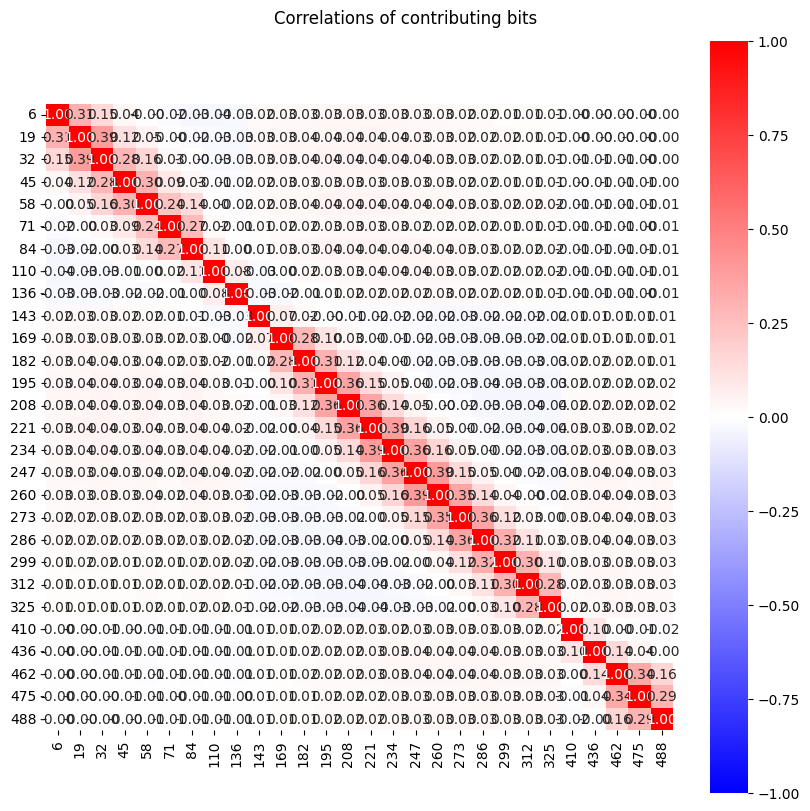

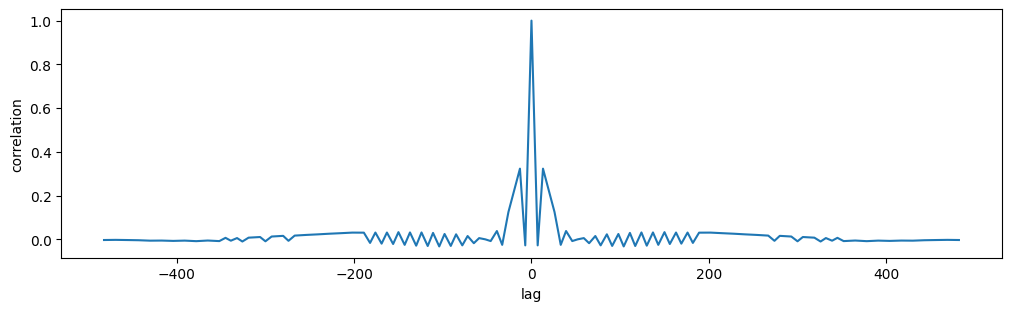

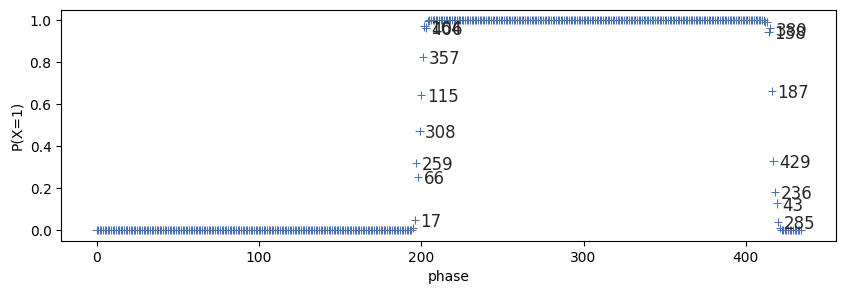

OK


INFO:TRNG Analysis:Doing experiment B_1 with params {'bit_pdf': True, 'bits_intra_correlation': True}
INFO:TRNG Analysis:Doing experiment C_2 with params {'bit_pdf': True, 'bits_intra_correlation': True}


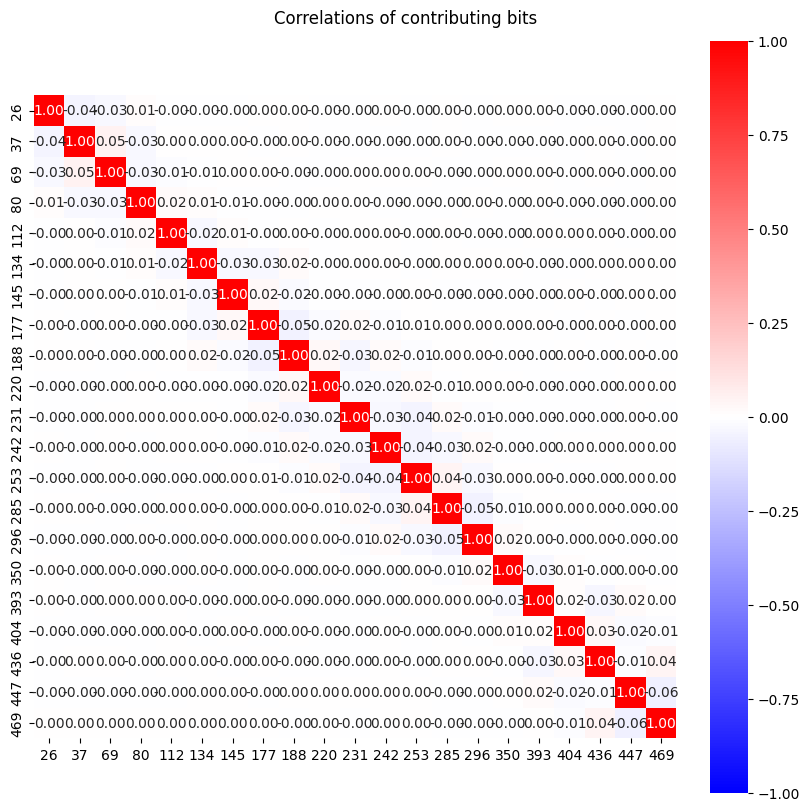

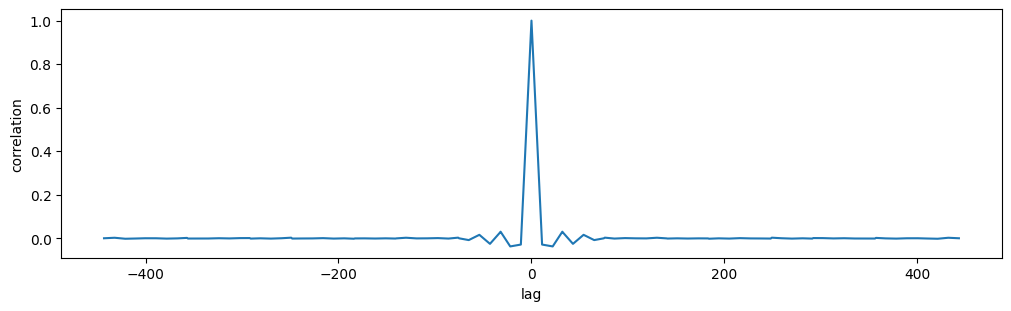

OK


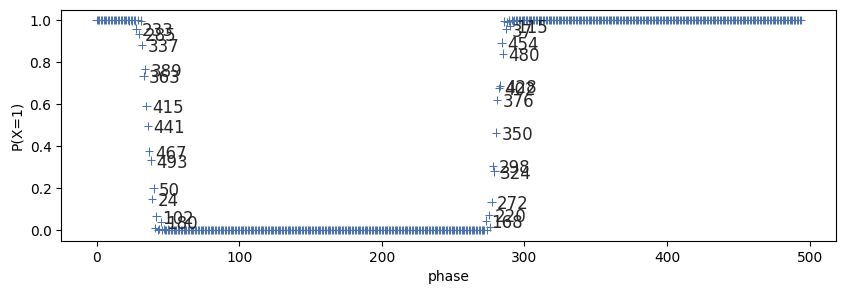

OK


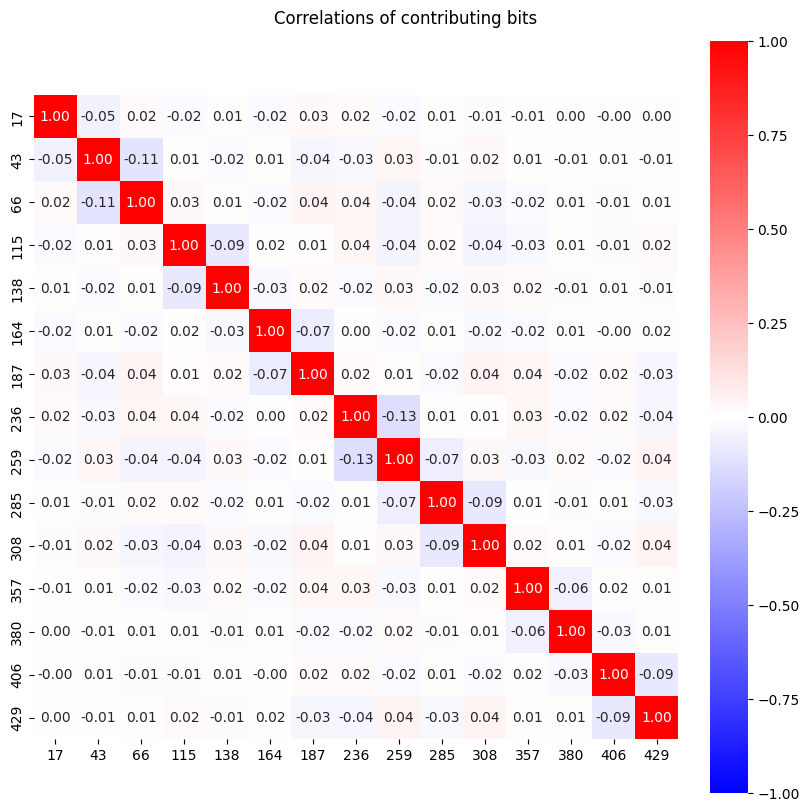

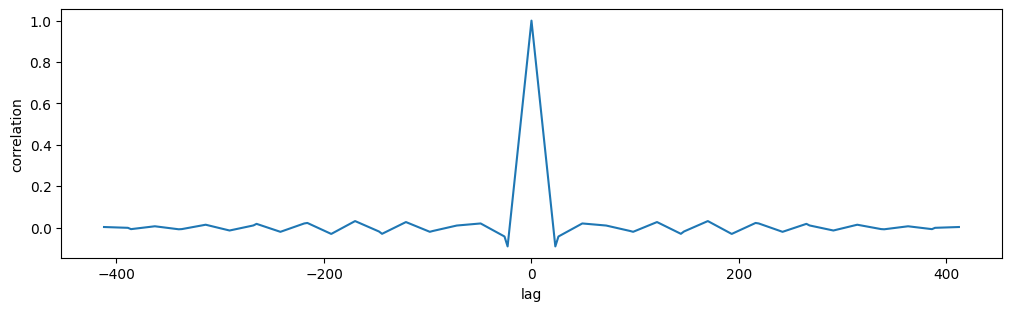

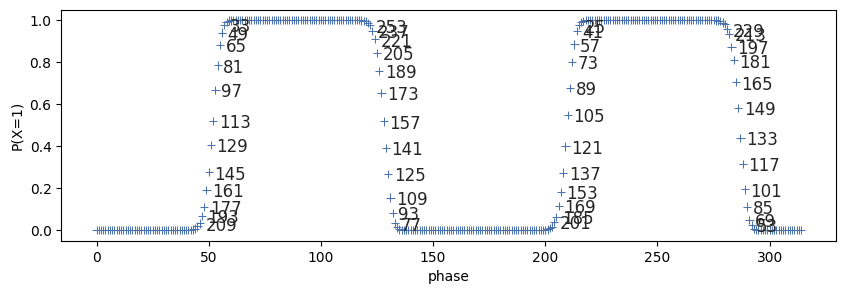

INFO:TRNG Analysis:Doing experiment A_1 with params {'bit_pdf': True, 'bits_intra_correlation': True}


OK


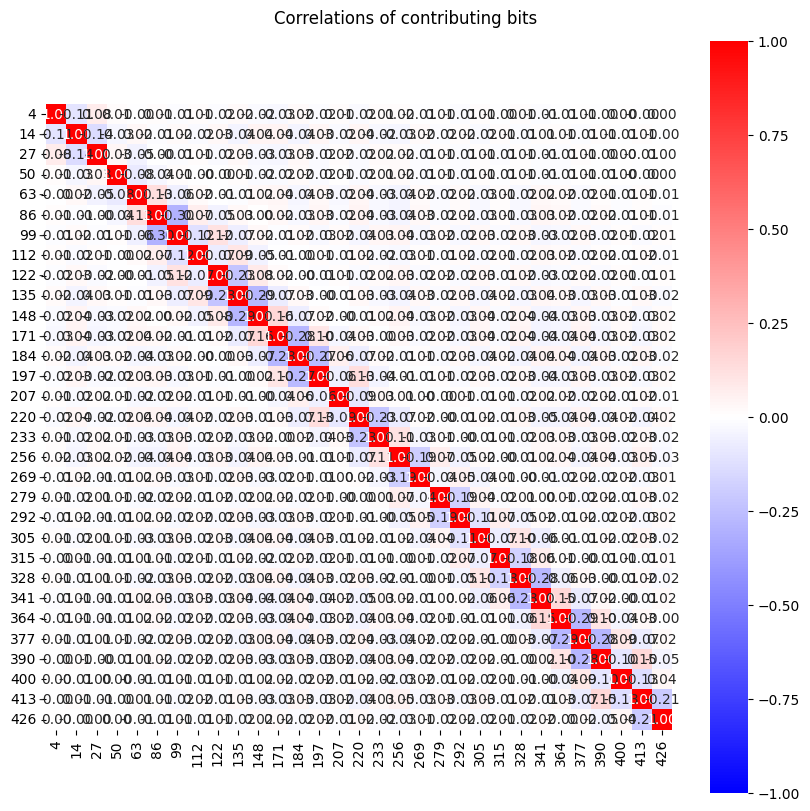

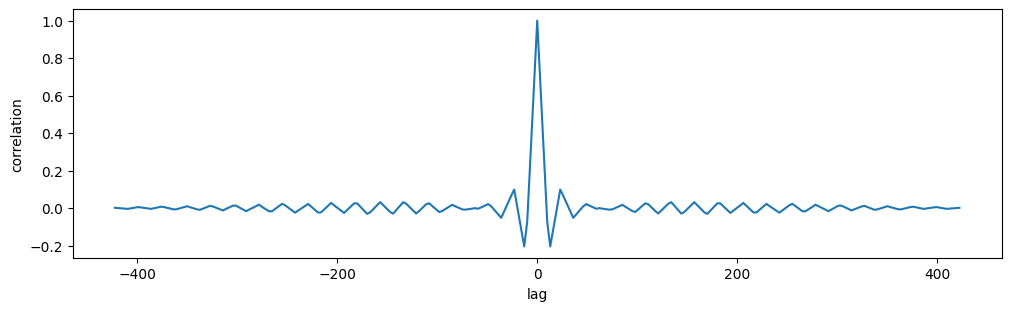

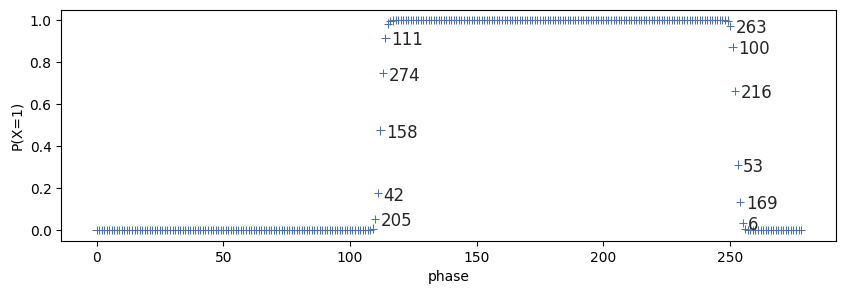

INFO:TRNG Analysis:Doing experiment A_2 with params {'bit_pdf': True, 'bits_intra_correlation': True}


OK


INFO:TRNG Analysis:Doing experiment B_2 with params {'bit_pdf': True, 'bits_intra_correlation': True}


OK


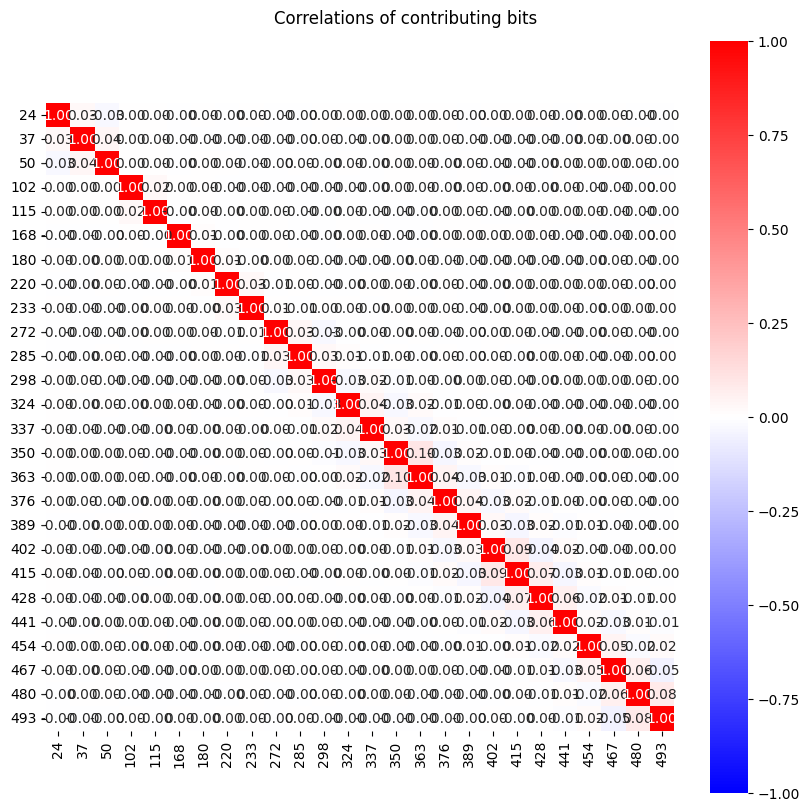

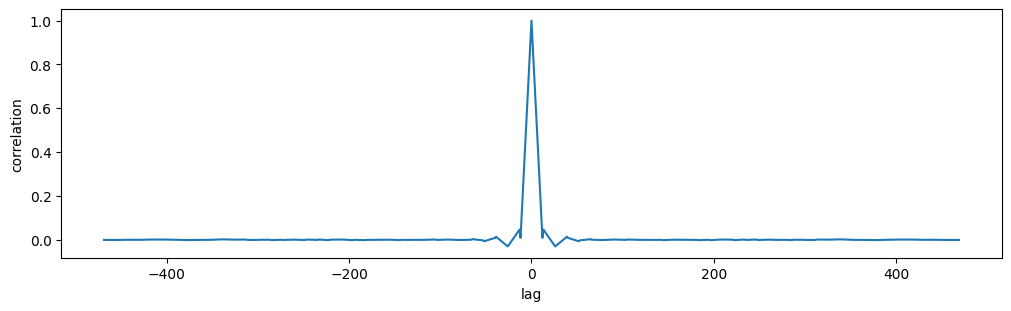

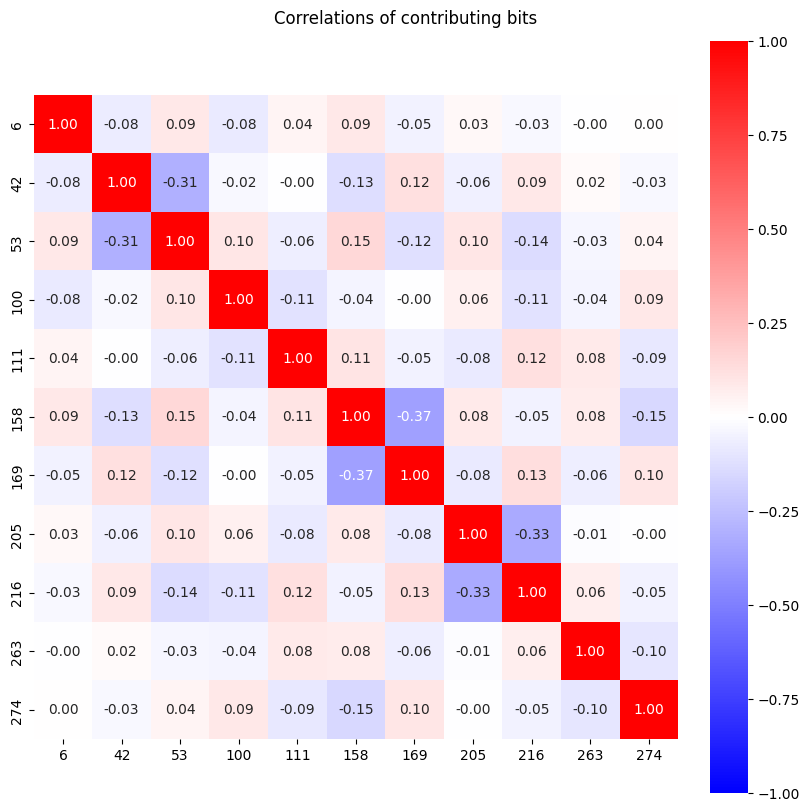

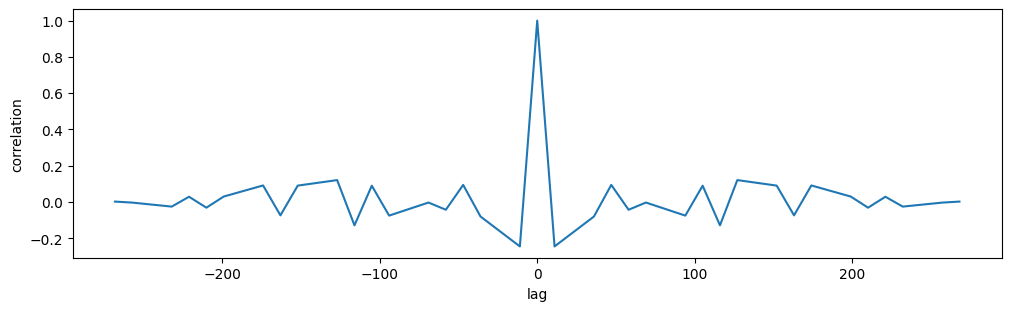

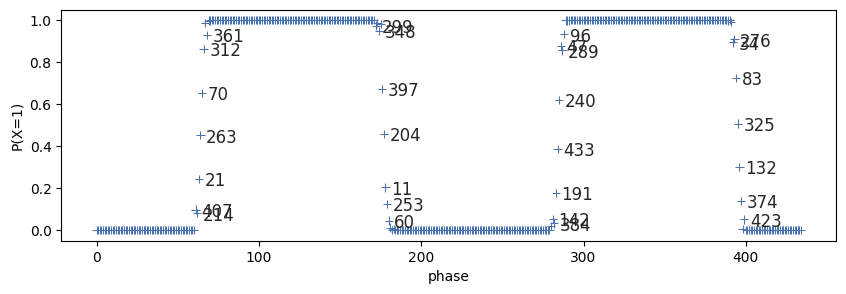

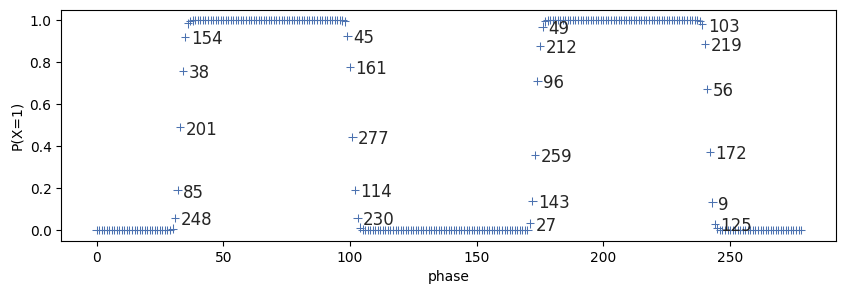

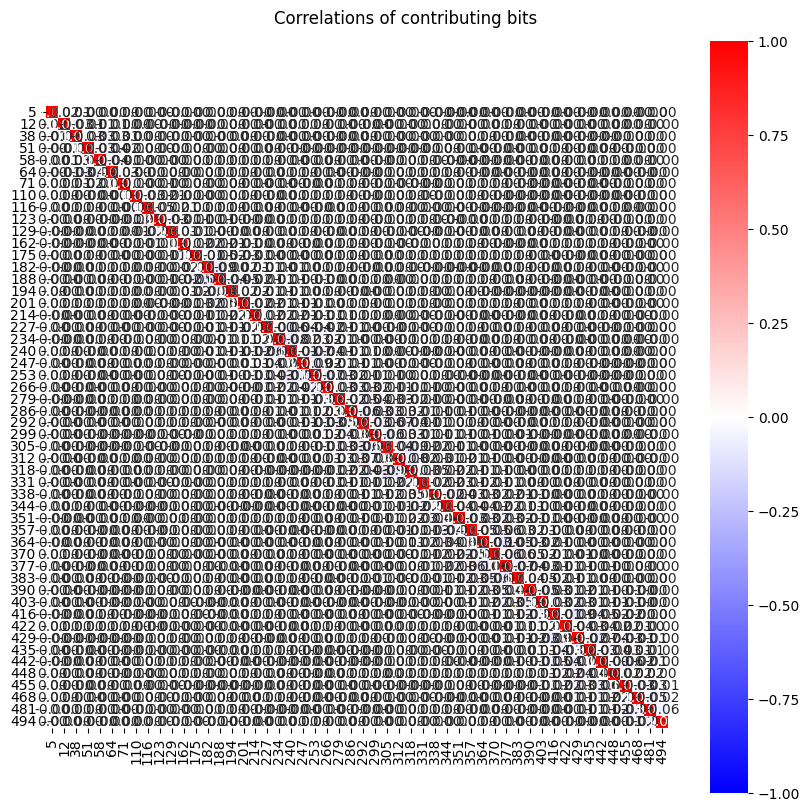

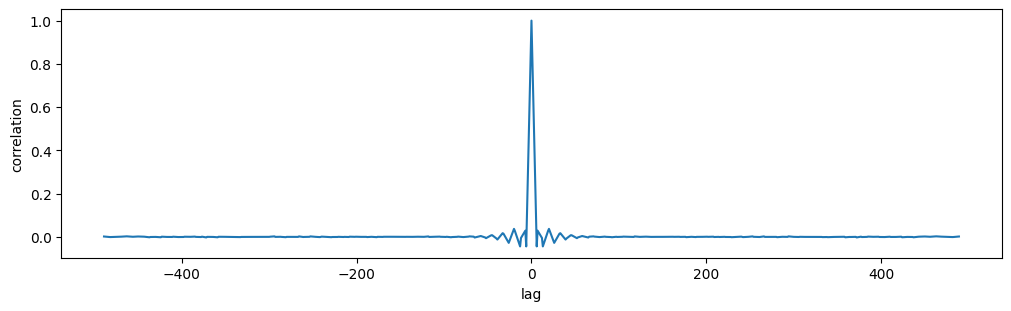

INFO:TRNG Analysis:Doing experiment A_1 with params {'bit_pdf': True, 'bits_intra_correlation': True}


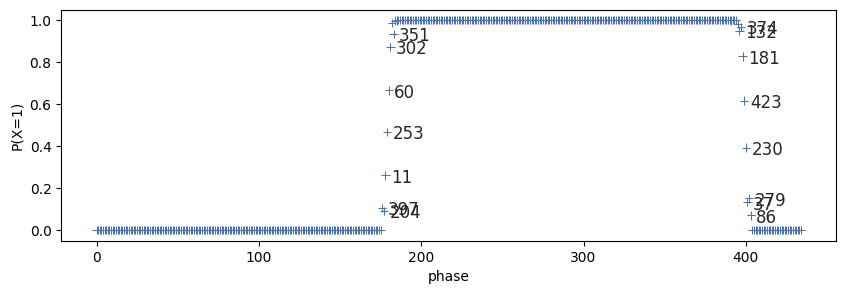

INFO:TRNG Analysis:Doing experiment C_1 with params {'bit_pdf': True, 'bits_intra_correlation': True}


OK
OK


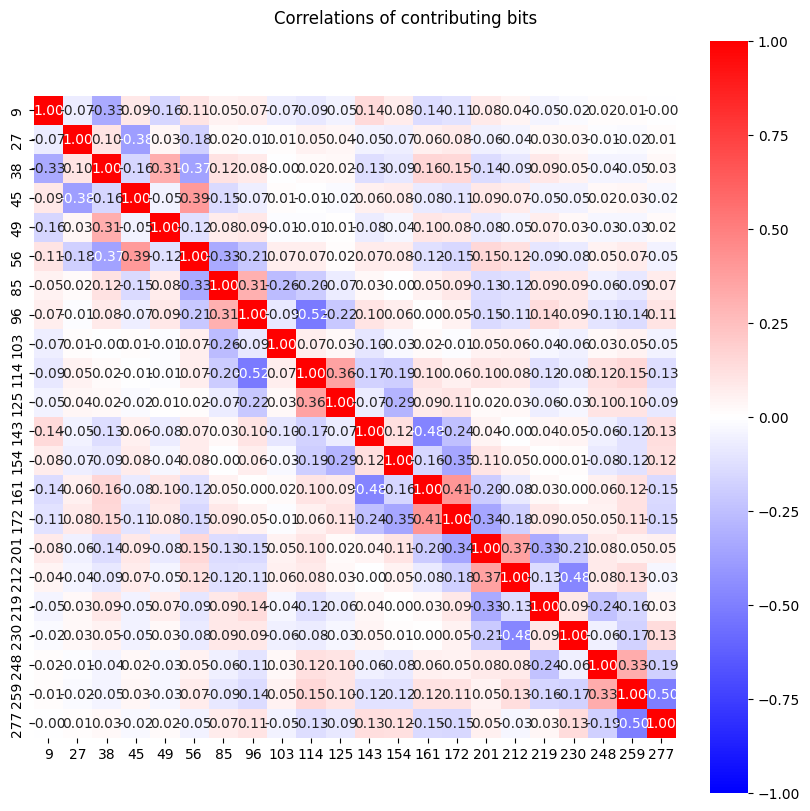

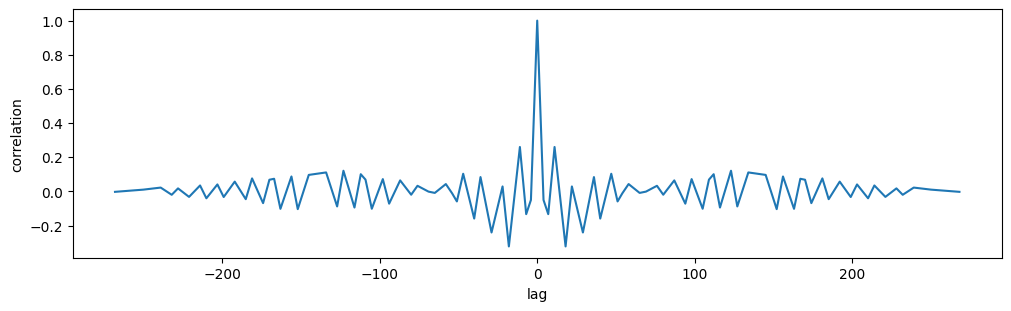

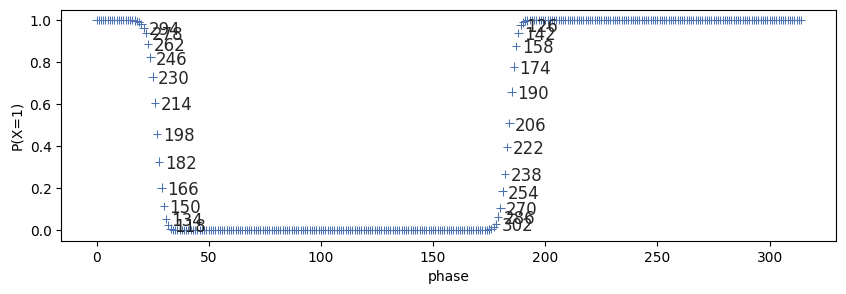

INFO:TRNG Analysis:Doing experiment A_2 with params {'bit_pdf': True, 'bits_intra_correlation': True}


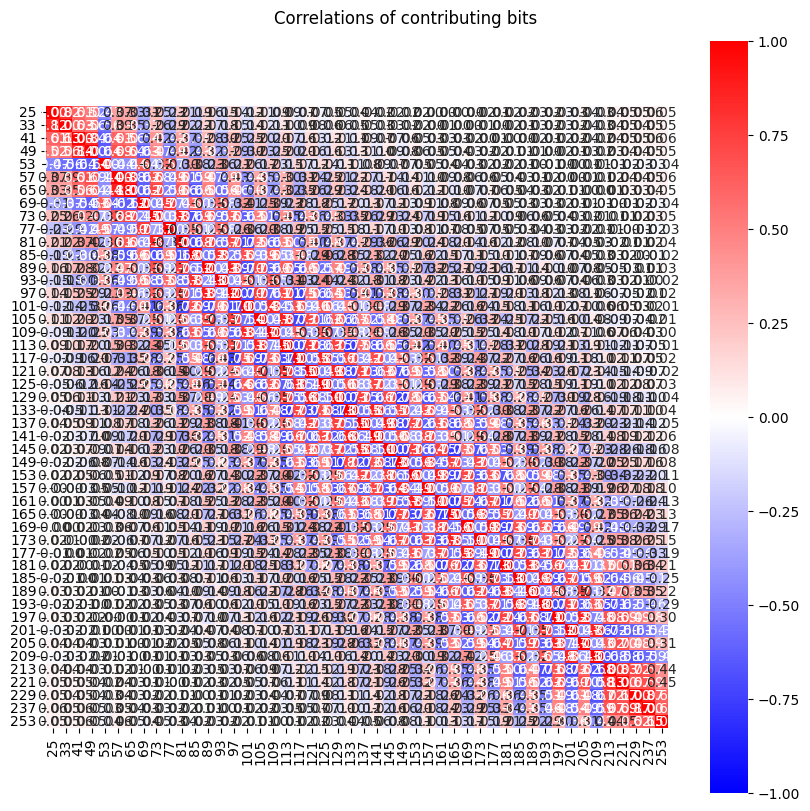

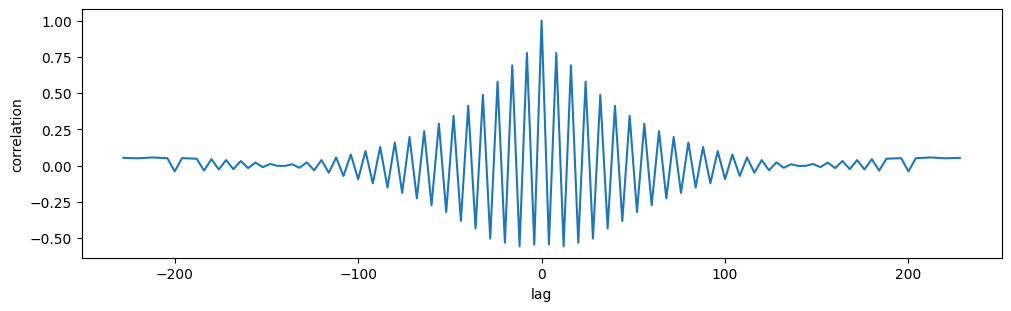

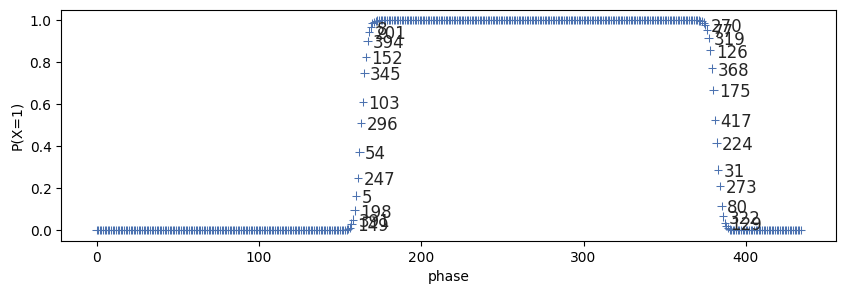

OK


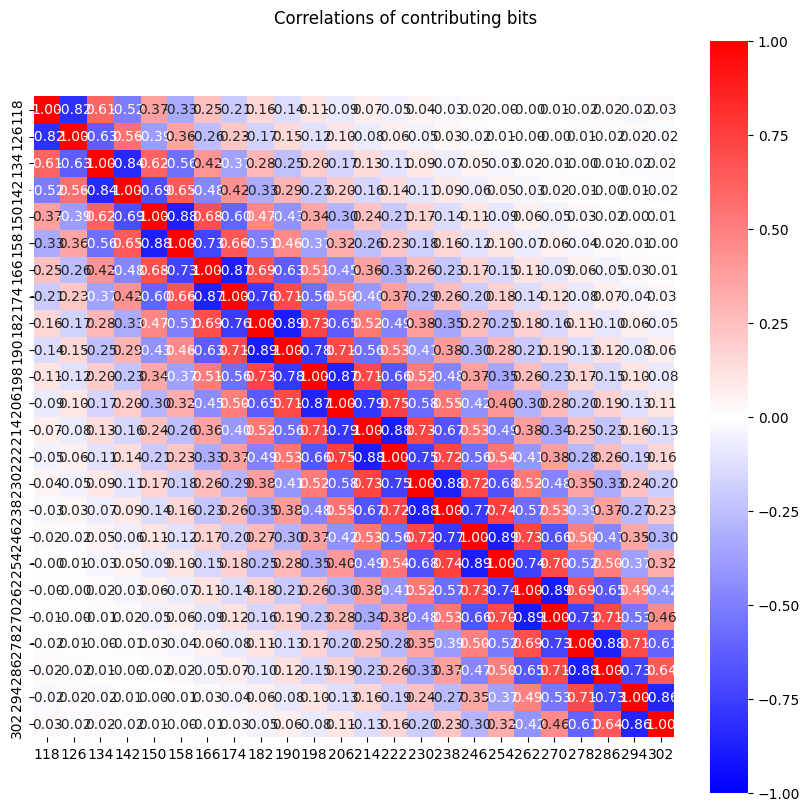

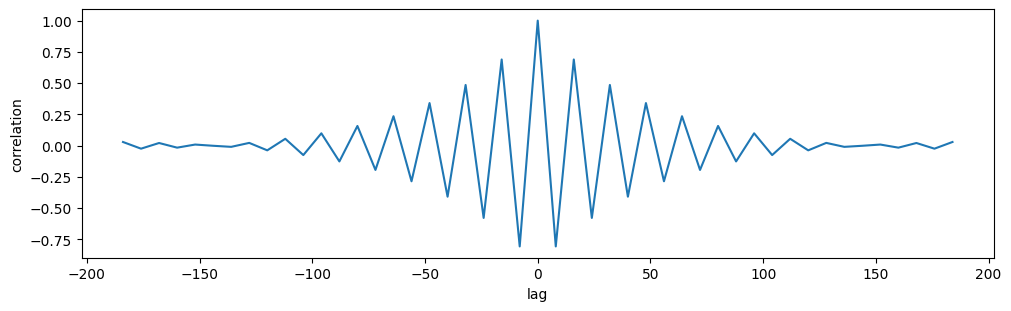

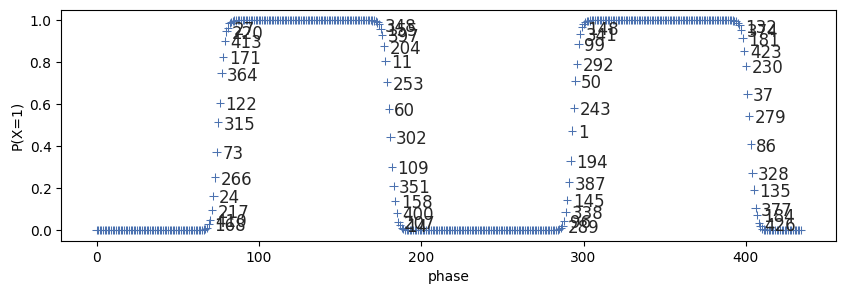

In [14]:
experiment_name = "Intra-Correlations"
experiment_id = mlflow.create_experiment(experiment_name)


def get_intra_correlations(cfg, threshold=0.02, nsamples=-1):
    """analyse intra-correlations"""
    logger.info(f"Doing experiment {cfg.name} with params {cfg.params}")
    with mlflow.start_run(experiment_id=experiment_id):
        mlflow.log_param("file", cfg.inputfile)
        mlflow.log_param("KM", cfg.KM)
        mlflow.log_param("KD", cfg.KD)
        mlflow.log_param("config", cfg.config)
        mlflow.log_param("pll", cfg.pll)
        mlflow.log_param("card", cfg.card)
        mlflow.log_param("constraint", cfg.constraint)
        mlflow.log_param("threshold", threshold)
        mlflow.log_param("nsamples", nsamples)
        KM = cfg.KM
        KD = cfg.KD
        bits = read_dff(cfg.inputfile, KM=KM, KD=KD)
        bits = bits[:nsamples, :]
        if cfg.params.get("bit_pdf"):
            ps = bits.mean(0)
            idx = np.arange(KD) * KM % KD
            fig, ax = plt.subplots(constrained_layout=True)
            df = pd.DataFrame(zip(idx, ps), columns=["phase", "P(X=1)"])
            mask = (df["P(X=1)"] > threshold) & (df["P(X=1)"] <= 1 - threshold)
            df.loc[mask, "text"] = df.index[mask].astype(str)
            df.to_csv("df.csv", index=False)
            print("OK")
            df["text"].fillna("", inplace=True)
            p = so.Plot(df, x="phase", y="P(X=1)", text="text").add(so.Dot(marker="+")).add(so.Text(halign="left"))
            p.on(ax).show()
            mlflow.log_figure(fig, "probability_density.svg")
        if cfg.params.get("bits_intra_correlation"):
            fig, ax = plt.subplots(figsize=(8, 8), constrained_layout=True)
            good_idx = np.arange(KD)[(ps > threshold) & (ps < 1 - threshold)]
            good_bits = bits[:, good_idx]
            corr_matrix = np.corrcoef(good_bits.T)
            var_emp = bits.sum(1).var()
            mlflow.log_metric("variance_empirical", var_emp)
            ps = good_bits.mean(0)
            var_iid = np.sum(ps * (1 - ps))
            mlflow.log_metric("variance_model_iid", var_iid)
            sns.heatmap(
                corr_matrix,
                cmap="bwr",
                vmin=-1,
                vmax=1,
                xticklabels=good_idx,
                yticklabels=good_idx,
                square=True,
                annot=True,
                fmt=".2f",
                ax=ax,
            )
            plt.suptitle(f"Correlations of contributing bits")
            mlflow.log_figure(fig, "bits_intra_correlation.svg")

            fig, ax = plt.subplots(constrained_layout=True)
            distances = good_idx.reshape(-1, 1) - good_idx.reshape(1, -1)
            lagged_corr = pd.DataFrame(data=zip(distances.ravel(), corr_matrix.ravel()), columns=["lag", "correlation"])
            lagged_corr = lagged_corr.groupby("lag").mean()
            sns.lineplot(data=lagged_corr, x="lag", y="correlation", ax=ax)
            mlflow.log_figure(fig, "bits_auto_correlation.svg")

            with tempfile.TemporaryDirectory() as tmpdir:
                fname = tmpdir + "/" + "bits_corr_matrix.csv"
                np.savetxt(fname, corr_matrix, delimiter=",")
                mlflow.log_artifact(fname)
                fname = tmpdir + "/" + "bits_indices.csv"
                np.savetxt(fname, good_idx, delimiter=",")
                mlflow.log_artifact(fname)
                fname = tmpdir + "/" + "bits_auto_correlation.csv"
                lagged_corr.to_csv(fname)
                mlflow.log_artifact(fname)


all_configs = itertools.chain(
    generate_configs_cyclonev(),
    generate_configs_spartan(),
    generate_configs_smartfusion(),
)

with mp.Pool(4) as p:
    p.map(get_intra_correlations, all_configs)

### Correlation decay

In [15]:
data = []
for _, r in mlflow.search_runs([experiment_id]).iterrows():
    fname = r.artifact_uri + "/bits_auto_correlation.csv"
    tmp = pd.read_csv(io.StringIO(mlflow.artifacts.load_text(fname)))
    tmp.loc[:, "Config"] = r["params.config"]
    tmp.loc[:, "PLL outputs"] = r["params.pll"]
    tmp.loc[:, "Card"] = r["params.card"]
    data.append(tmp)

data = pd.concat(data)
data["Config"] = data["Config"].str.upper().astype("category")
data.to_csv("intra_correlations_agg.csv")

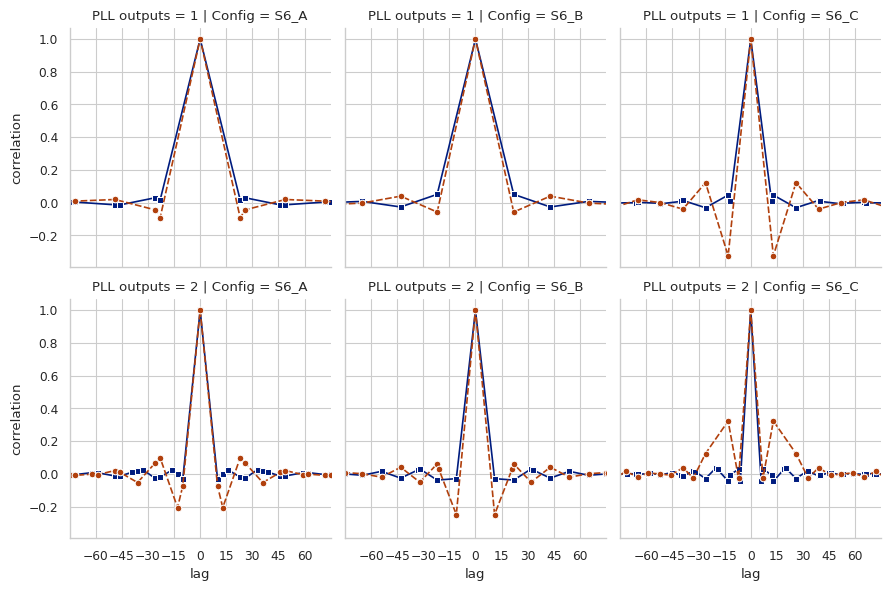

In [16]:
plt.style.use("ggplot")
sns.set_theme(context="paper", style="whitegrid", palette="dark")

mask = data["Config"].str.slice(0, 2) == "S6"
data = data[mask]
data["Config"] = data["Config"].cat.remove_unused_categories()
g = sns.FacetGrid(
    data, col="Config", row="PLL outputs", legend_out=True, sharey=True, sharex="col", row_order=["1", "2"]
)
g.map_dataframe(
    sns.lineplot, x="lag", y="correlation", hue="Card", dashes=True, style="Card", markers={"v11_2": "o", "v11_8": "s"}
)
# g.add_legend(title='Card version')
g.set(xticks=(-60, -45, -30, -15, 0, 15, 30, 45, 60))
X_LIM = (-75, 75)
g.axes[1][0].set_xlim(*X_LIM)
g.axes[1][1].set_xlim(*X_LIM)
g.axes[1][2].set_xlim(*X_LIM)
plt.tight_layout()
g.figure.savefig("intra_correlations_agg_S6.svg")
plt.show()

# Download Results

Download and zip all the figures generated into the current Colab project.

In [17]:
for _, r in mlflow.search_runs(experiment_id).iterrows():
    config = r["params.config"]
    pll = r["params.pll"]
    card = r["params.card"]
    run_id = r["run_id"]
    result_dir = f"results/{config}_{pll}_{card}"
    mlflow.artifacts.download_artifacts(run_id=run_id, artifact_path="bits_intra_correlation.svg", dst_path=result_dir)
    mlflow.artifacts.download_artifacts(run_id=run_id, artifact_path="bits_auto_correlation.svg", dst_path=result_dir)
    mlflow.artifacts.download_artifacts(run_id=run_id, artifact_path="probability_density.svg", dst_path=result_dir)

!zip -r -qq results.zip results

Display autocorrelations

Display stationary/dependency tests in one matrix.

In [18]:
out_all = pd.concat(
    [out_locstationary, out_stationarity, out_correlation],
    axis=1,
    keys=["Stationarity", "Stationarity", "Autocorrelation"],
)
out_all

ALPHA = 0.01

style_TRNG_OK = "color:Green; font-weight: bold"
out_all = (
    out_all.style.format(precision=2, escape="latex")
    .applymap(lambda x: style_TRNG_OK if x >= ALPHA else "", subset=[("Autocorrelation", "counter", "LjungBox")])
    .applymap(lambda x: style_TRNG_OK if x >= ALPHA else "", subset=[("Autocorrelation", "raw bit", "LjungBox")])
    .applymap(lambda x: style_TRNG_OK if x > ALPHA else "", subset=[("Stationarity", "dff", "loc-KPSS")])
    .applymap(lambda x: style_TRNG_OK if x > ALPHA else "", subset=[("Stationarity", "counter", "KPSS")])
    .applymap(lambda x: style_TRNG_OK if x > ALPHA else "", subset=[("Stationarity", "raw bit", "KPSS")])
    .applymap(lambda x: style_TRNG_OK if x < ALPHA else "", subset=[("Stationarity", "counter", "ADF")])
    .applymap(lambda x: style_TRNG_OK if x < ALPHA else "", subset=[("Stationarity", "raw bit", "ADF")])
)

display(out_all)

latex_code = out_all.to_latex(
    hrules=True,
    convert_css=True,
    position_float="centering",
    caption="Results of stationarity and serial correlation tests",
    label="tab:serial_correlation_and_stationarity",
)

latex_code = latex_code.replace("_A", "\_A")
latex_code = latex_code.replace("_B", "\_B")
latex_code = latex_code.replace("_C", "\_C")
latex_code

'\\begin{table}\n\\centering\n\\caption{Results of stationarity and serial correlation tests}\n\\label{tab:serial_correlation_and_stationarity}\n\\begin{tabular}{llrrrrrrr}\n\\toprule\n &  & \\multicolumn{5}{r}{Stationarity} & \\multicolumn{2}{r}{Autocorrelation} \\\\\n & contributors & dff & \\multicolumn{2}{r}{counter} & \\multicolumn{2}{r}{raw bit} & counter & raw bit \\\\\n & test & loc-KPSS & KPSS & ADF & KPSS & ADF & LjungBox & LjungBox \\\\\nconfig & card &  &  &  &  &  &  &  \\\\\n\\midrule\nCV\\_A & CV1 & \\color{Green} \\bfseries 0.10 & 0.01 & \\color{Green} \\bfseries 0.00 & \\color{Green} \\bfseries 0.10 & \\color{Green} \\bfseries 0.00 & 0.00 & \\color{Green} \\bfseries 0.07 \\\\\n\\multirow[c]{2}{*}{S6\\_A} & S61 & \\color{Green} \\bfseries 0.10 & \\color{Green} \\bfseries 0.07 & \\color{Green} \\bfseries 0.00 & \\color{Green} \\bfseries 0.06 & \\color{Green} \\bfseries 0.00 & \\color{Green} \\bfseries 0.63 & \\color{Green} \\bfseries 0.36 \\\\\n & S62 & \\color{Green} \\